## CUSUM Algorithm

### Introduction
CUSUM (Cumulative Sum Control Chart) is a sequential analysis technique typically used for monitoring change detection. It is used in various industries for quality control, and it is effective in detecting small shifts from the process mean.

### Mathematical Formulation

The CUSUM algorithm is based on the cumulative sum of the deviations of the process measurements from a target value (typically the mean). The algorithm can be broken down into two equations: one for positive changes (CUSUM+) and another for negative changes (CUSUM−).

#### CUSUM+ (Positive Changes)

$$
S^+_k = \max(0, S^+_{k-1} + x_k - \mu_0 - k)
$$

Where:
- $ S^+_k $ is the cumulative sum for positive changes up to point $ k $.
- $ x_k $ is the data point at time $ k $.
- $ \mu_0 $ is the target value or mean.
- $ k $ is a reference value or allowance, typically a small positive number.

#### CUSUM− (Negative Changes)

$$
S^-_k = \min(0, S^-_{k-1} + x_k - \mu_0 + k)
$$

Where:
- $ S^-_k $ is the cumulative sum for negative changes up to point $ k $.

### Decision Rule

A change is detected when the absolute value of $ S^+_k $ or $ S^-_k $ exceeds a certain threshold value $ h $, which is determined based on the desired sensitivity of the control chart.

$$
\text{Change detected if } |S^+_k| > h \text{ or } |S^-_k| > h
$$

### Reset Mechanism

After a change is detected, the CUSUM values are typically reset to zero to prepare for monitoring future changes.

$$
S^+_k = 0 \text{ and } S^-_k = 0 \text{ after change detection}
$$

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
import numpy as np

In [5]:
# Read data and set timestamp as index:S
data = pd.read_parquet("data/solar_generation.parquet")
data = data.set_index("dtm")

In [6]:
data.head()

plantId        sourceKey  pow_dc  pow_ac  yield_daily  \
dtm                                                                          
2020-05-15 00:00:00  4135001  1BY6WEcLGh8j5v7     0.0     0.0          0.0   
2020-05-15 00:15:00  4135001  1BY6WEcLGh8j5v7     0.0     0.0          0.0   
2020-05-15 00:30:00  4135001  1BY6WEcLGh8j5v7     0.0     0.0          0.0   
2020-05-15 00:45:00  4135001  1BY6WEcLGh8j5v7     0.0     0.0          0.0   
2020-05-15 01:00:00  4135001  1BY6WEcLGh8j5v7     0.0     0.0          0.0   

                     yield_total  temp_ambient  temp_module  irradiation  \
dtm                                                                        
2020-05-15 00:00:00    6259559.0     25.184316    22.857507          0.0   
2020-05-15 00:15:00    6259559.0     25.084589    22.761668          0.0   
2020-05-15 00:30:00    6259559.0     24.935753    22.592306          0.0   
2020-05-15 00:45:00    6259559.0     24.846130    22.360852          0.0   
2020-05-15 01:00:00    6259559.0     24.621525    22.165423          0.0   

                     time_local  
dtm                              
2020-05-15 00:00:00        0.00  
2020-05-15 00:15:00        0.25  
2020-05-15 00:30:00        0.50  
2020-05-15 00:45:00        0.75  
2020-05-15 01:00:00        1.00

# Re-sample daily:

In [7]:
cols_resample = ["pow_dc", "pow_ac", "yield_daily", "yield_total", "temp_ambient", "temp_module", "irradiation"]
df = data.groupby("sourceKey")[cols_resample].resample("D").mean()
df = df.reset_index()

# Cumsum

In [8]:
def cumsum(series: pd.Series, mu_0: float, k: float, h: float) -> (np.array, np.array):
    """
        CUMSUM Change Point Detection given a pandas Series. It returns boolean mask for positive and negative change point flags.
    Args:
        series: Series to detect change points.
        mu_0: Target value or mean
        k: Allowance
        h: Threshold
    Returns
        (np.array, np.array)
    """
    S_plus = [0]
    S_minus = [0]
    flags_positive = [False] * len(series)
    flags_negative = [False] * len(series)

    for i in range(1, len(series)):
        S_plus.append(max(0, S_plus[i-1] + series.iloc[i] - mu_0 - k))
        S_minus.append(min(0, S_minus[i-1] + series.iloc[i] - mu_0 + k))

        if S_plus[i] > h:
            flags_positive[i] = True
            S_plus[i] = 0  # Reset after change detection
        elif abs(S_minus[i]) > h:
            flags_negative[i] = True
            S_minus[i] = 0  # Reset after change detection

    return np.array(flags_positive), np.array(flags_negative)

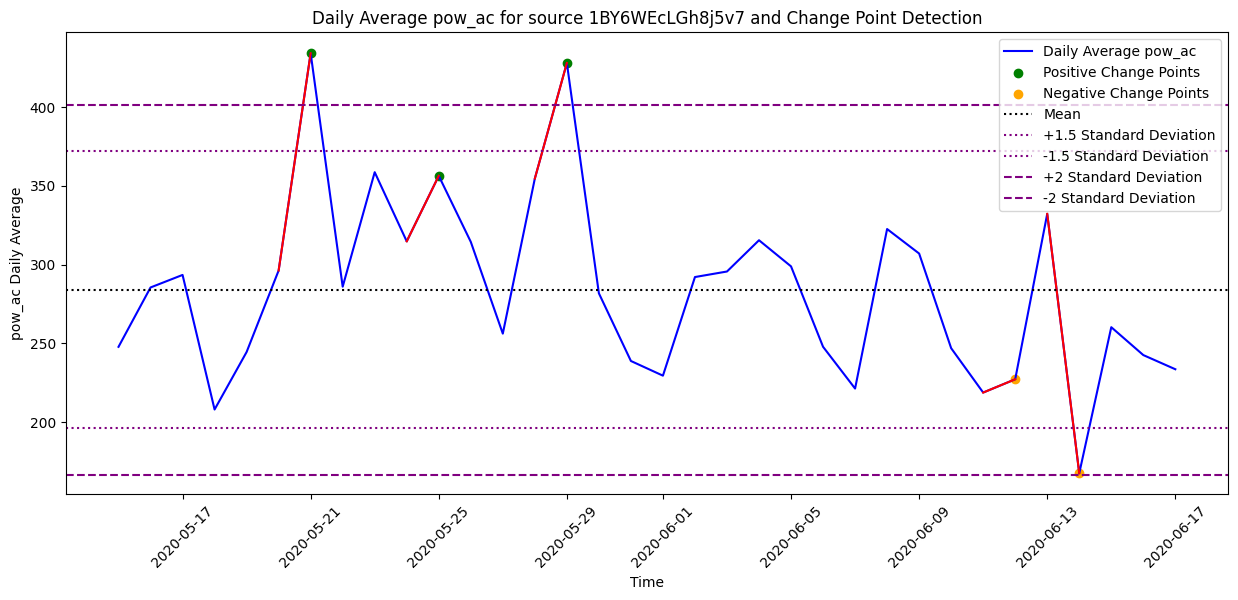

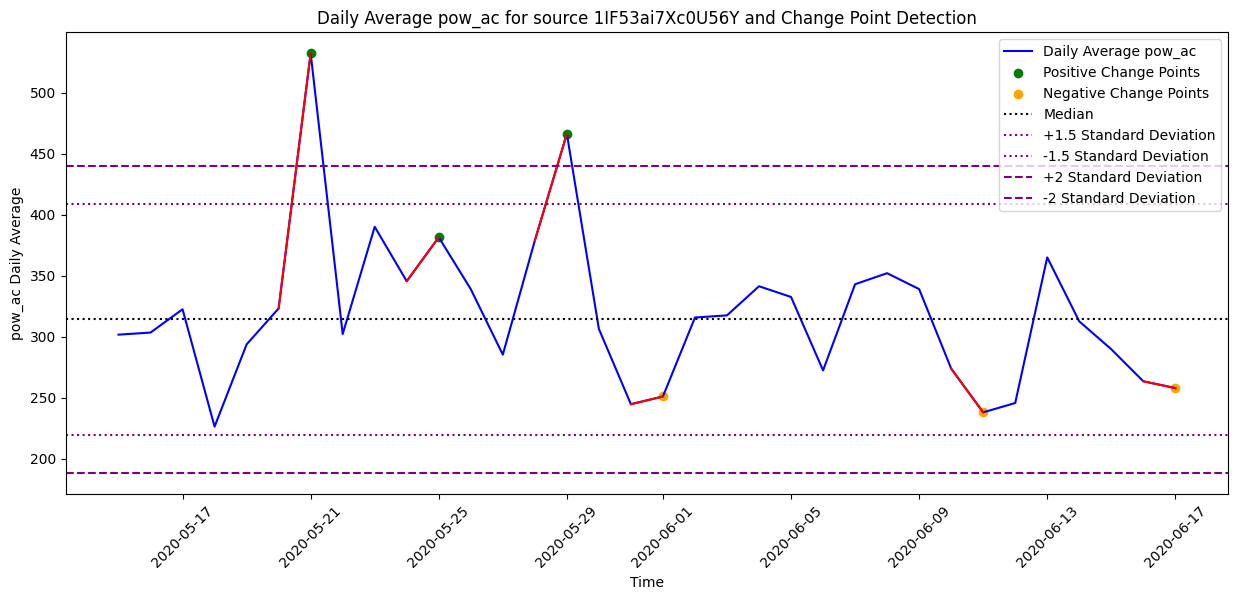

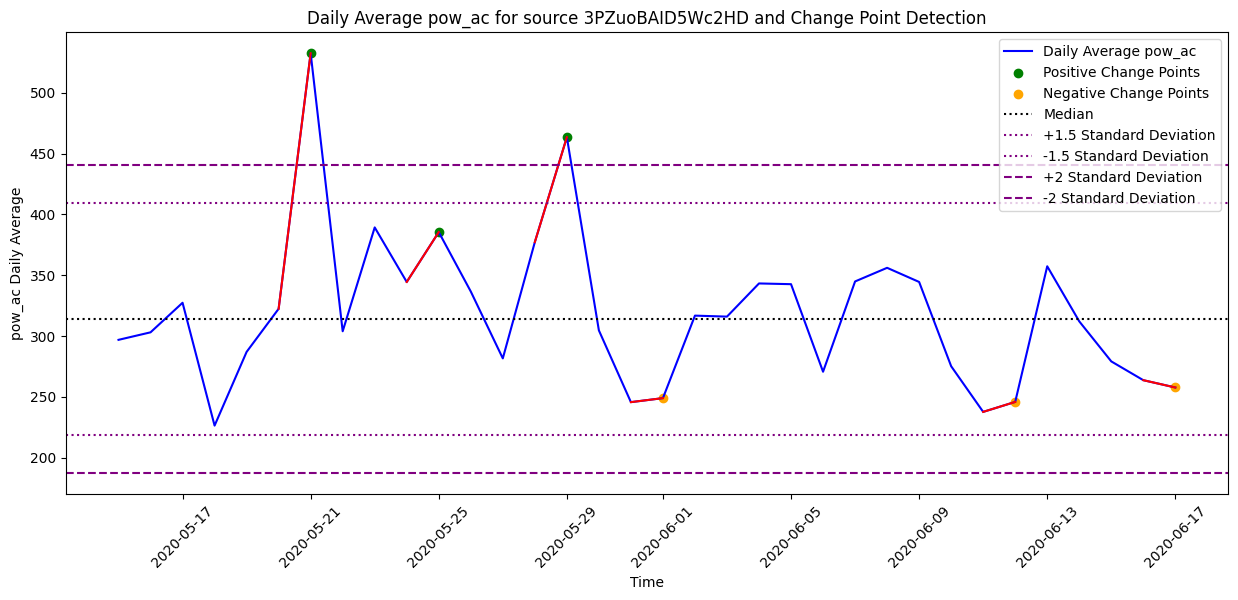

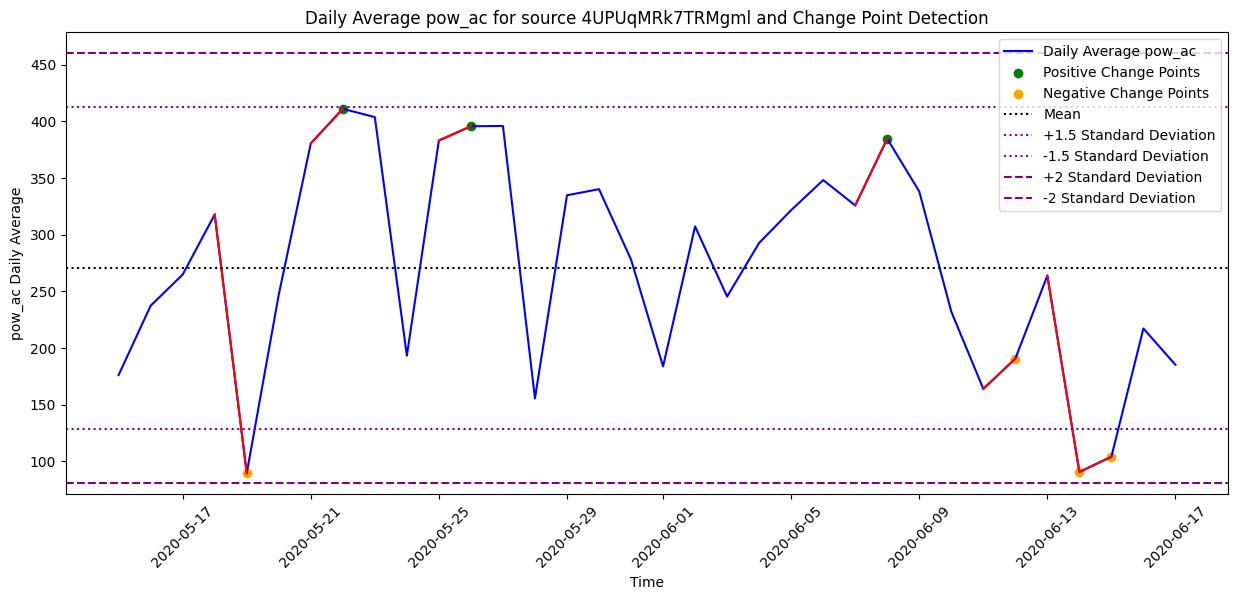

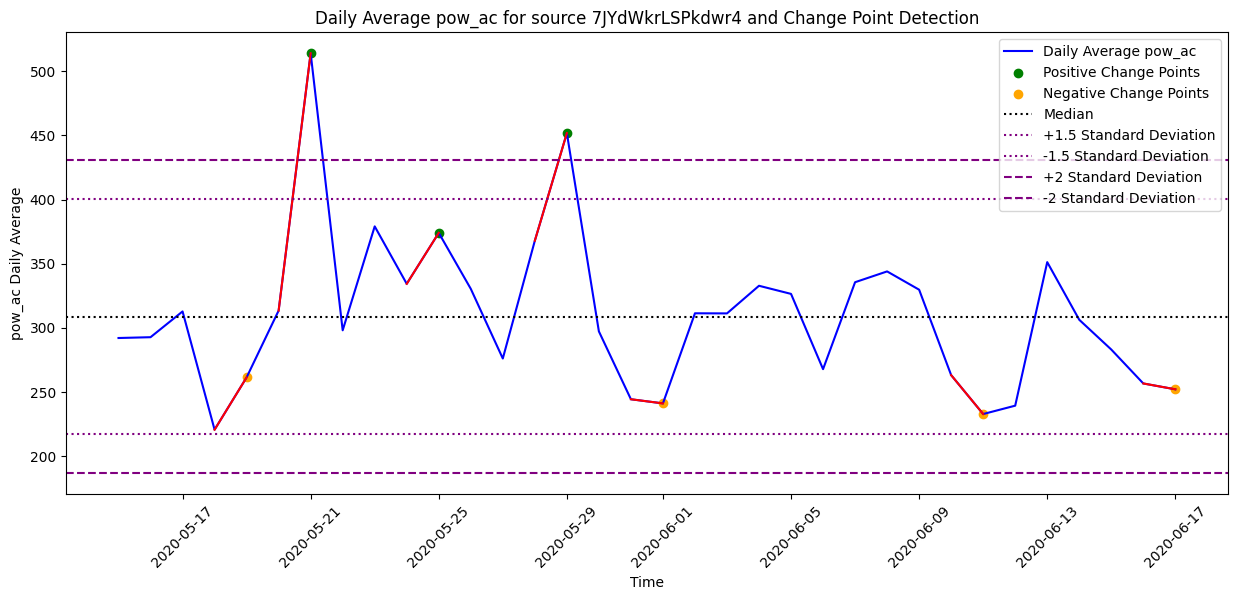

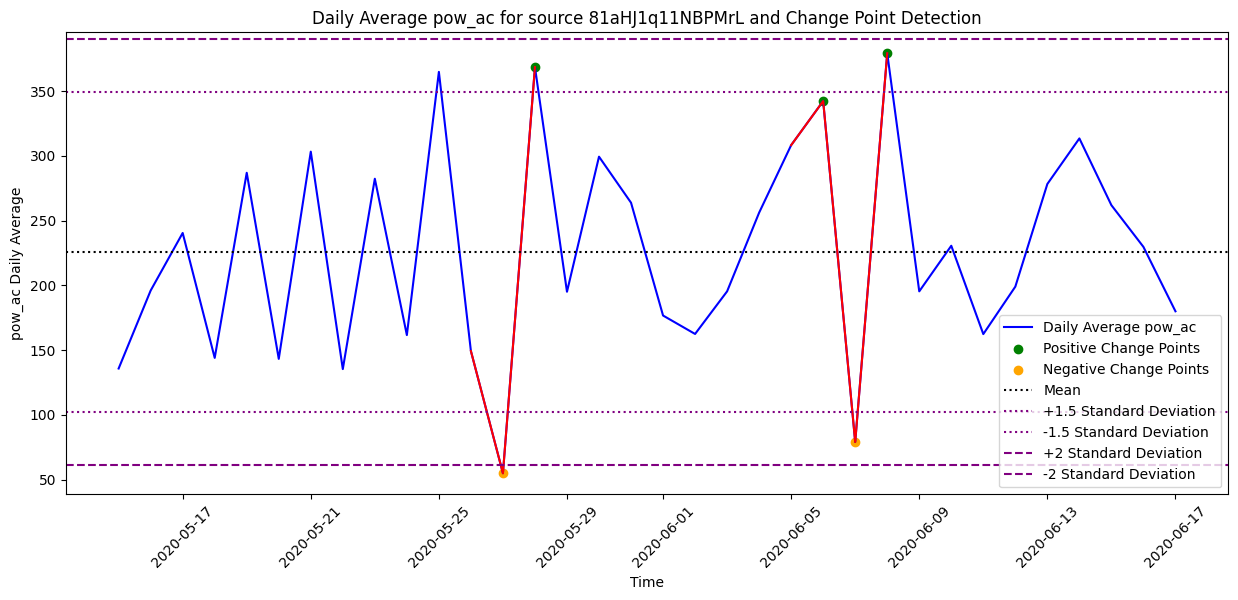

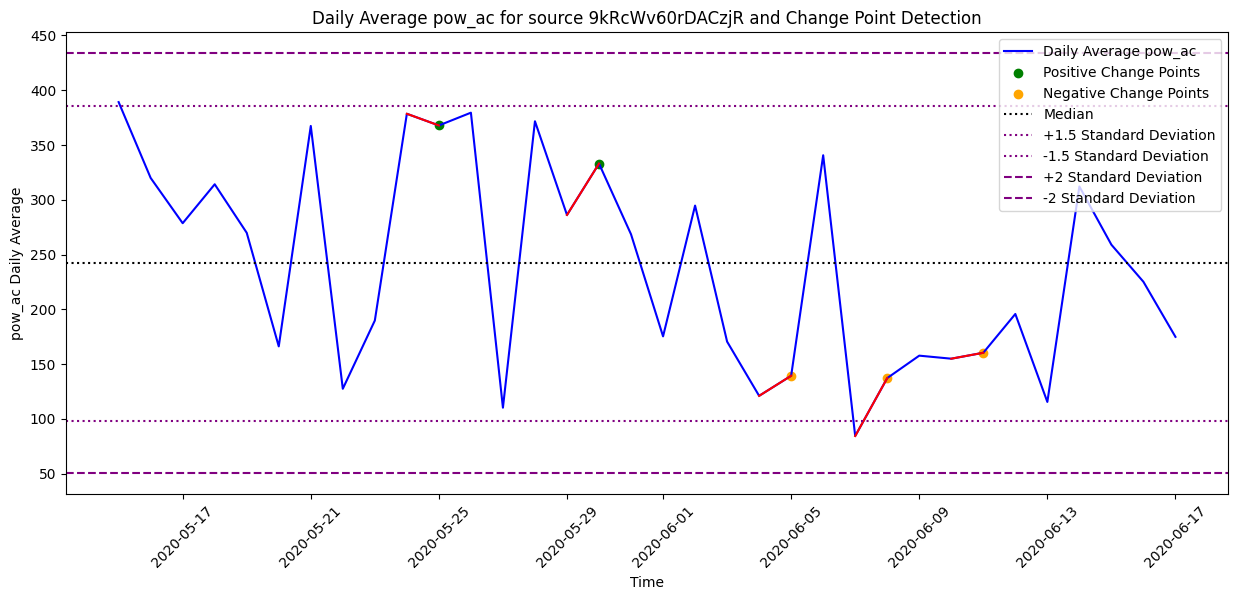

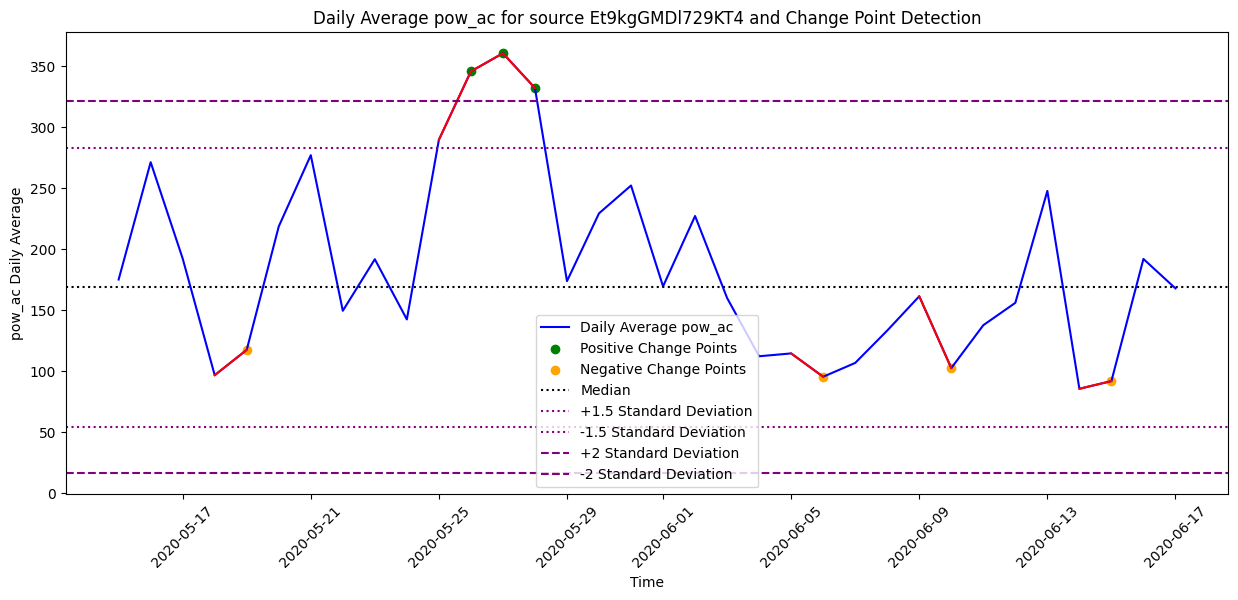

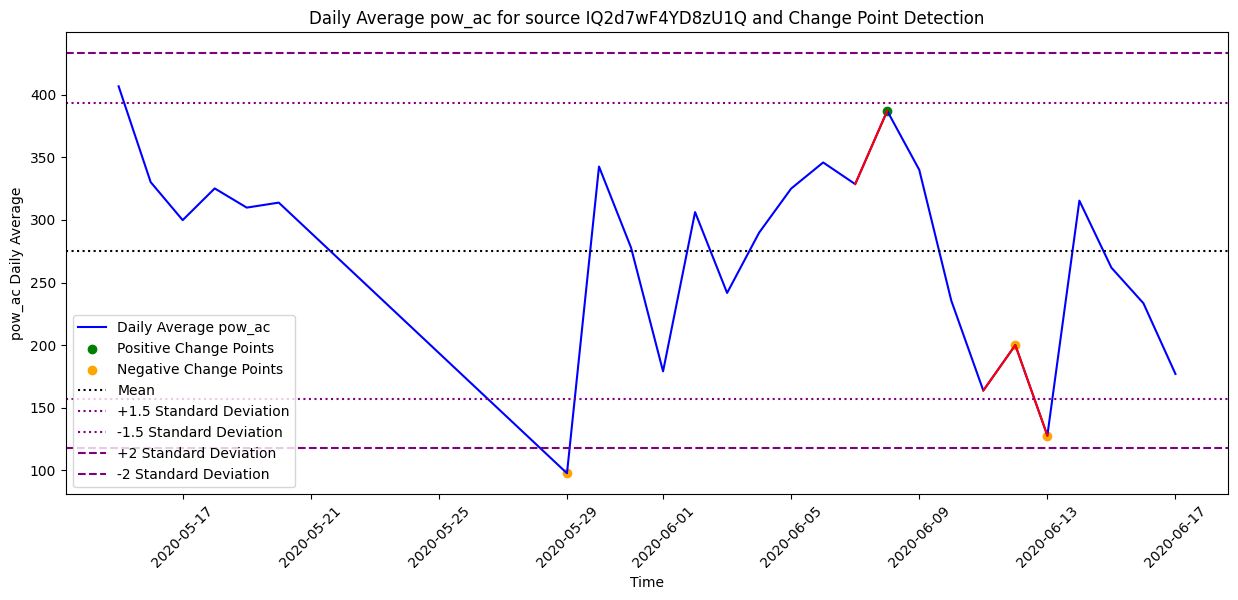

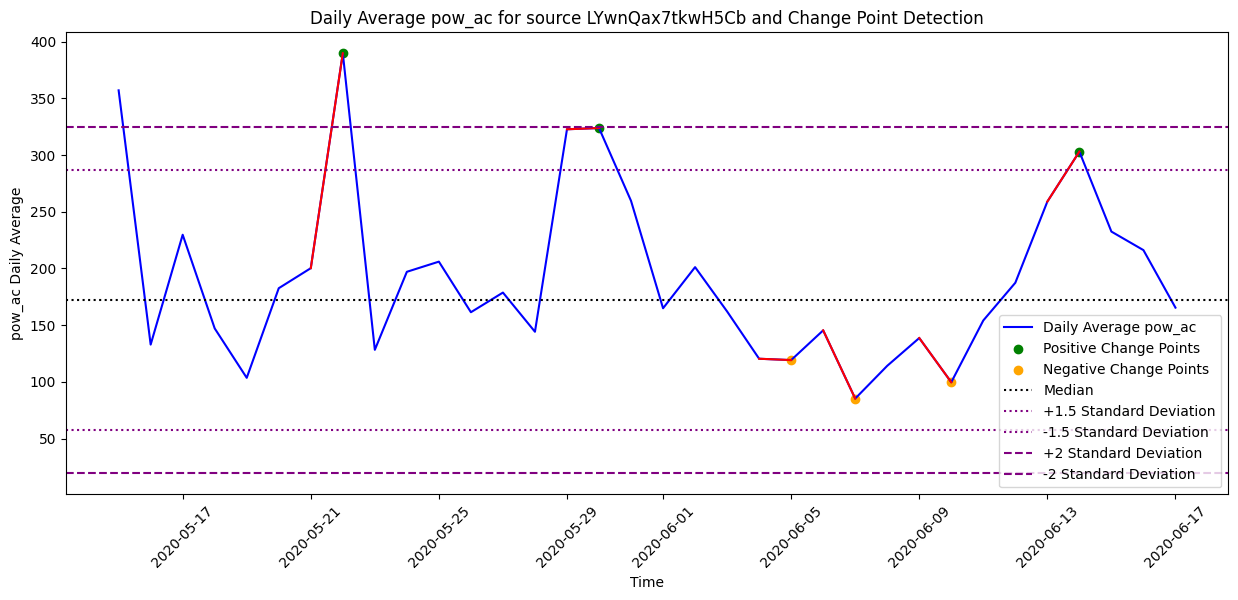

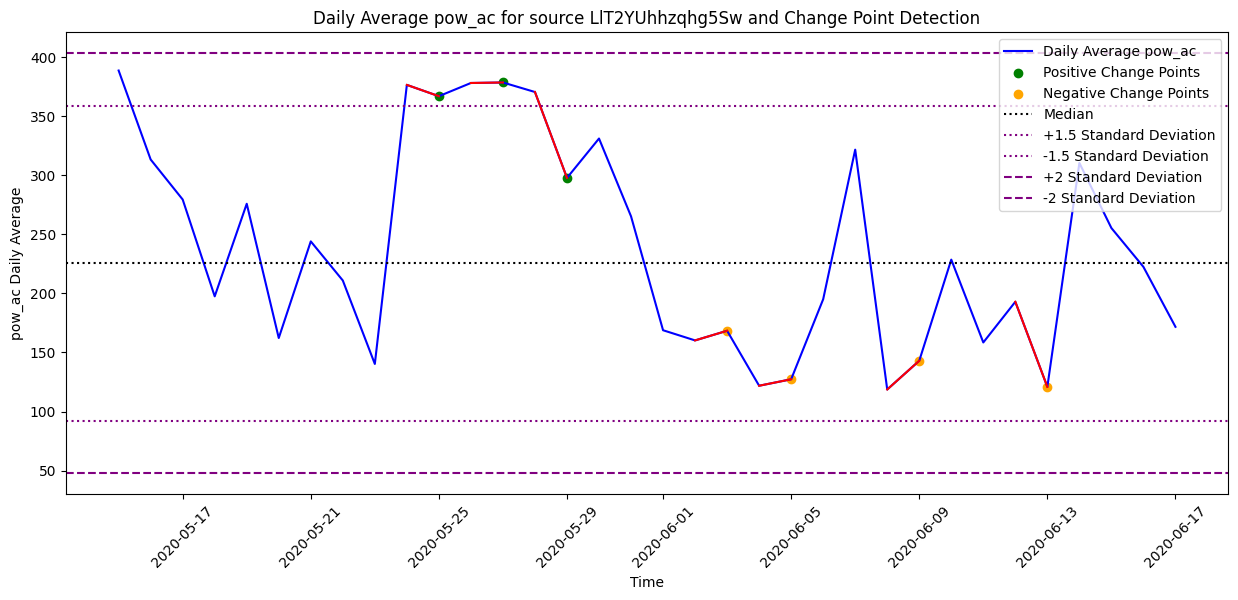

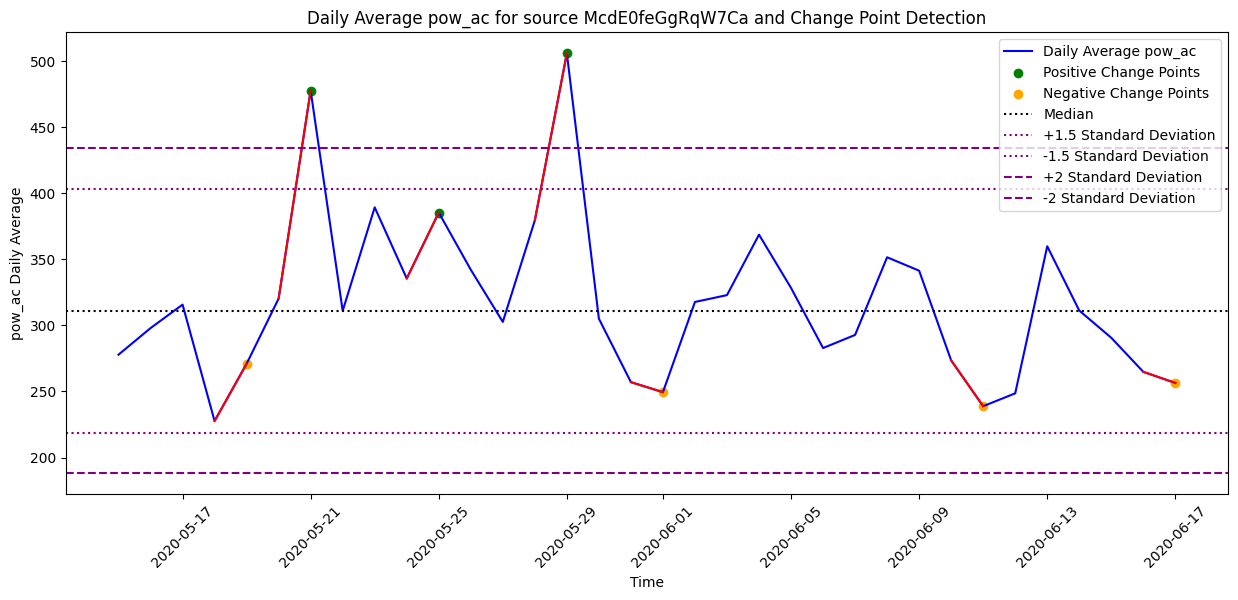

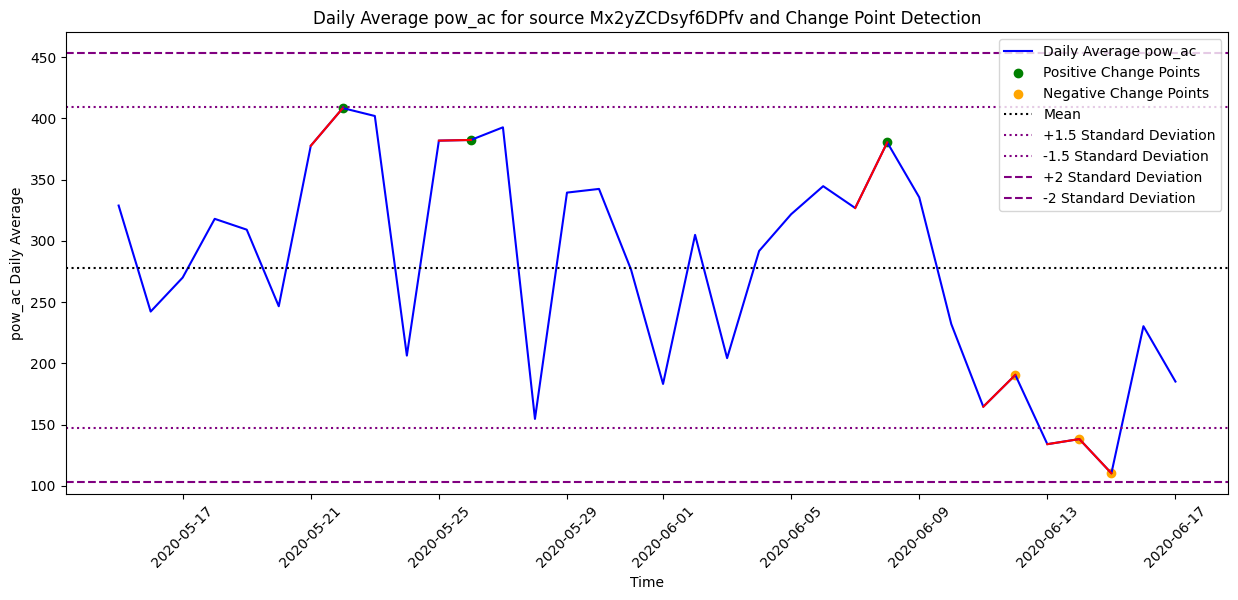

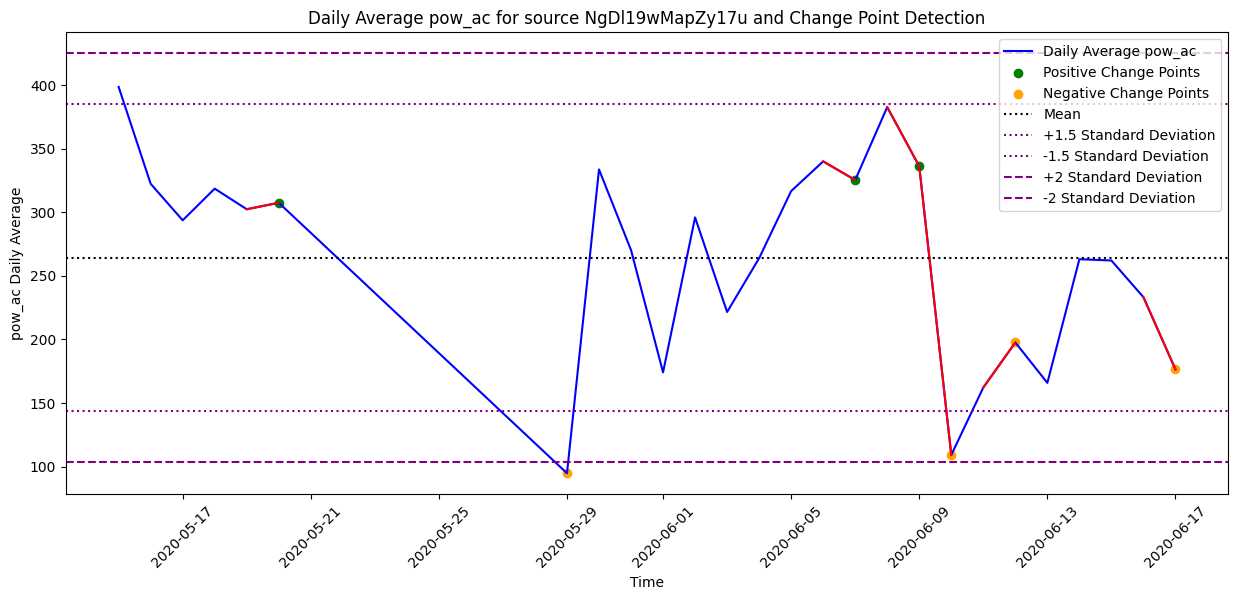

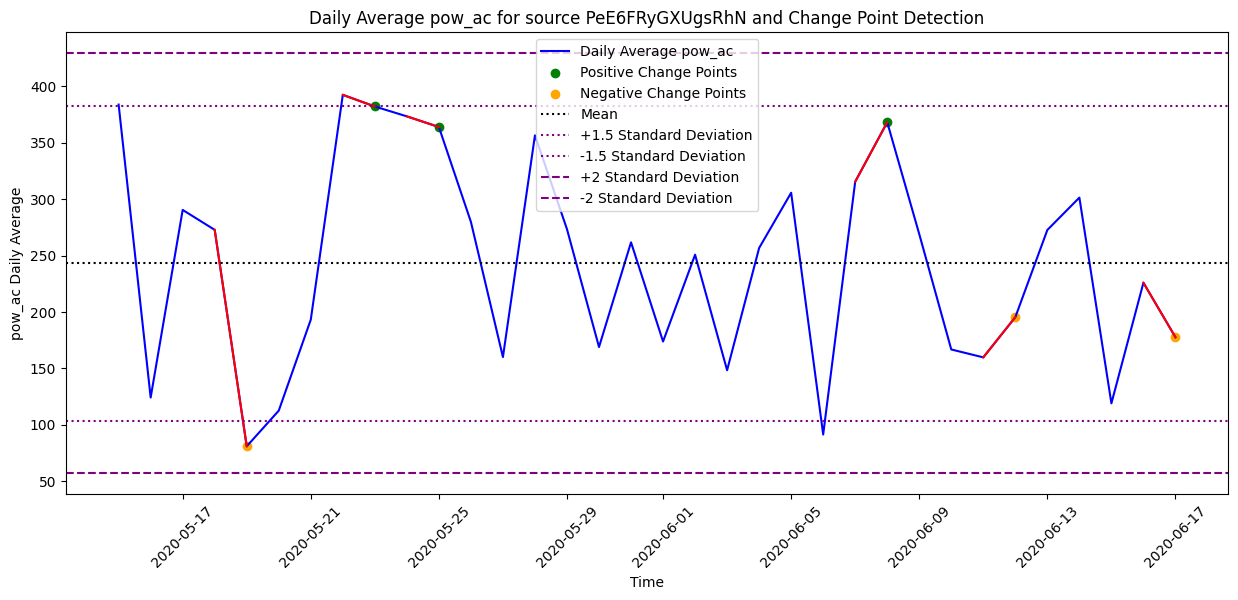

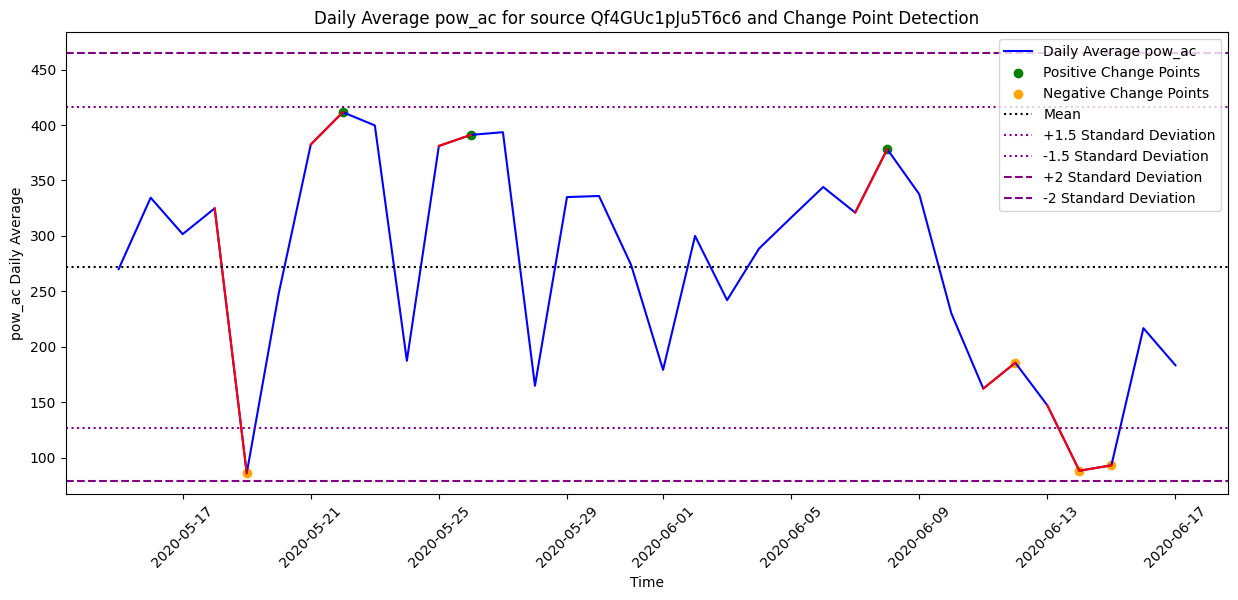

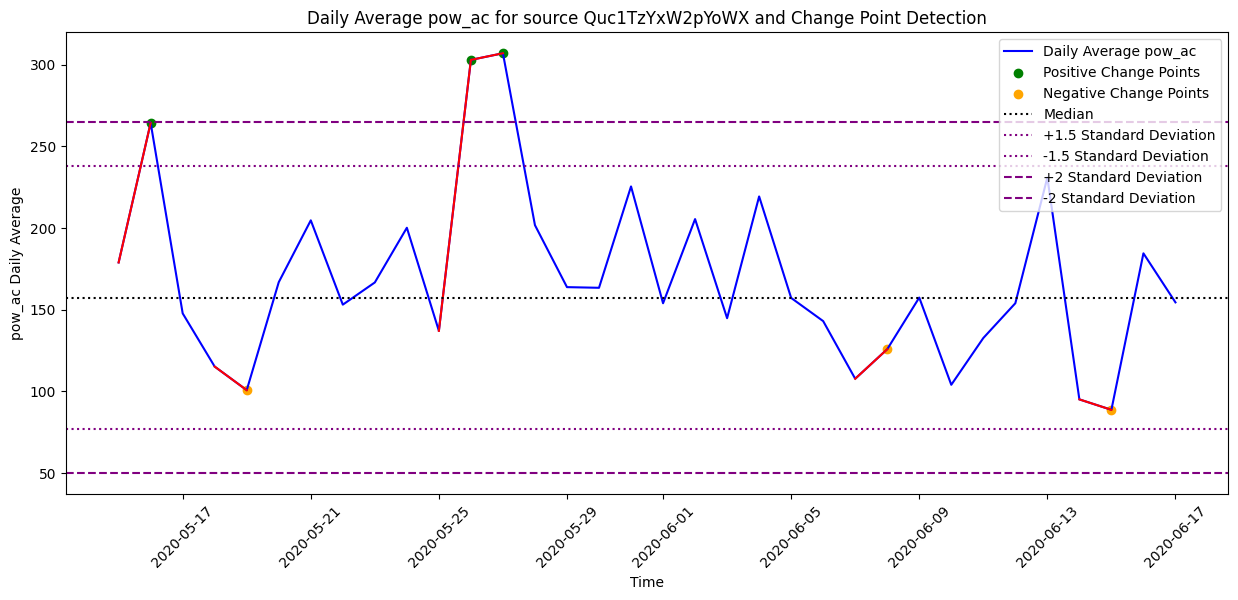

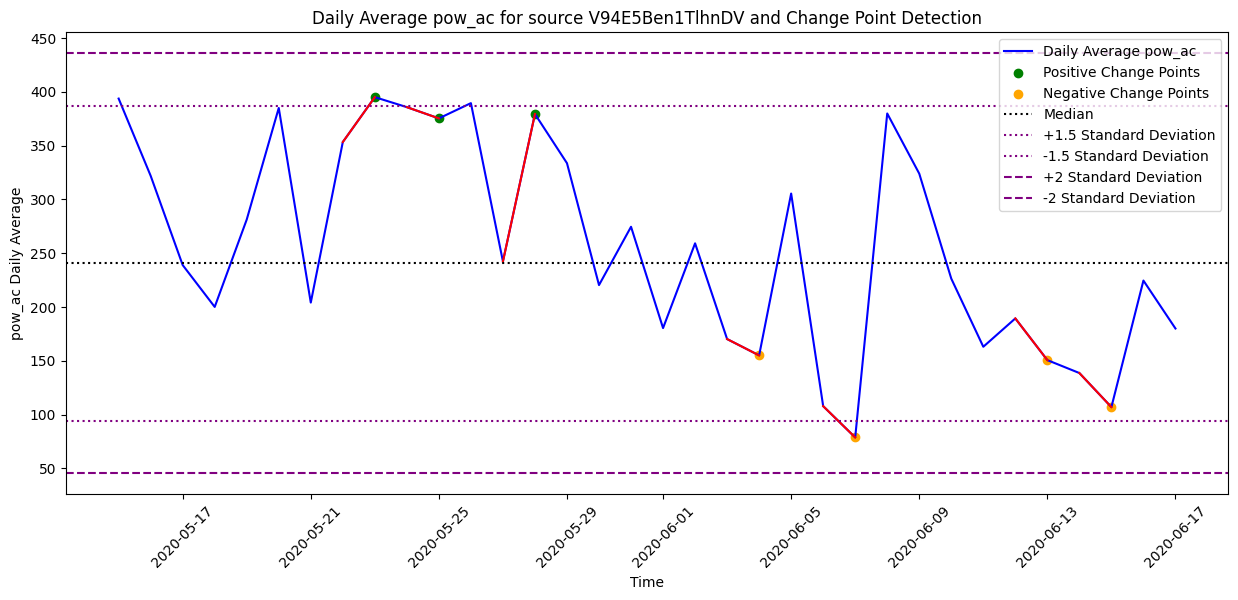

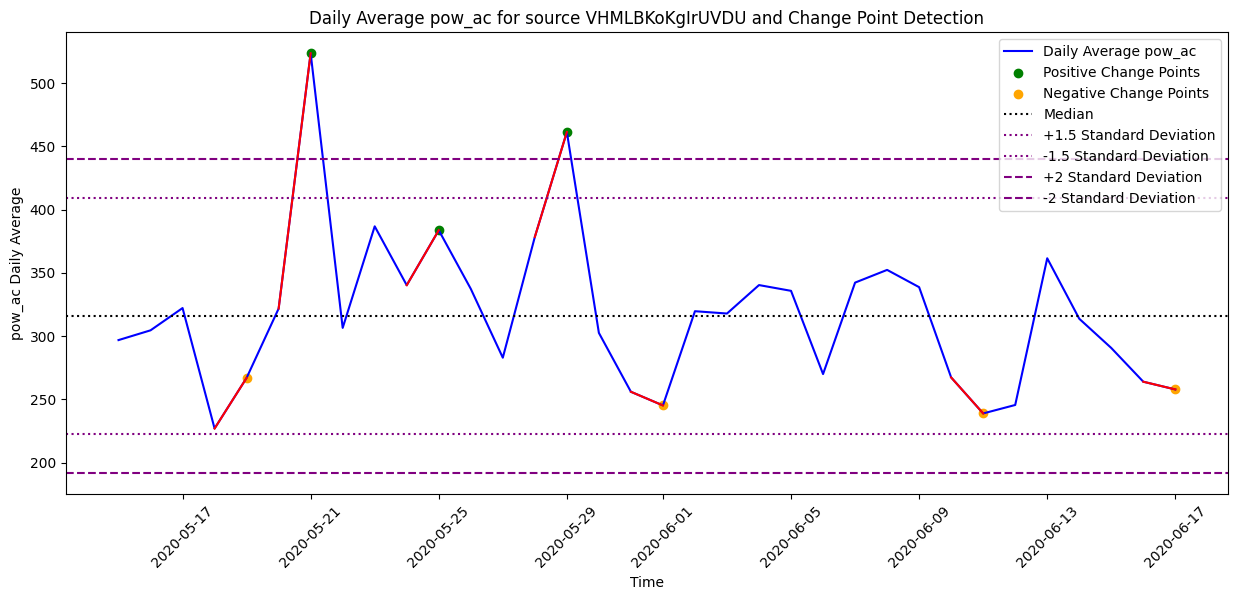

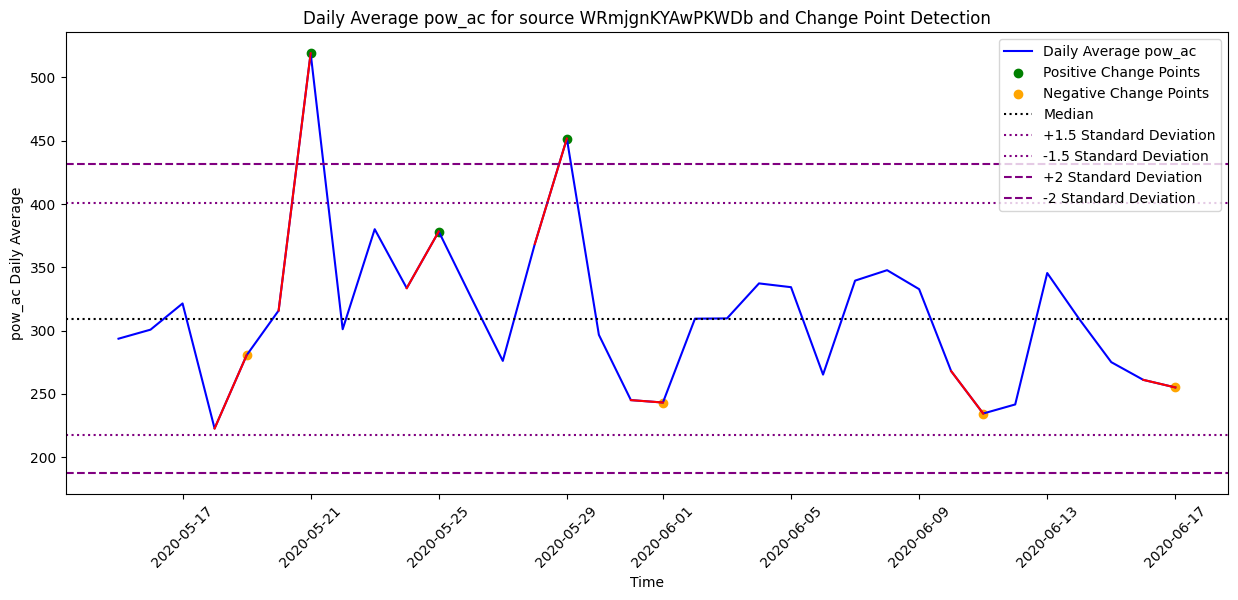

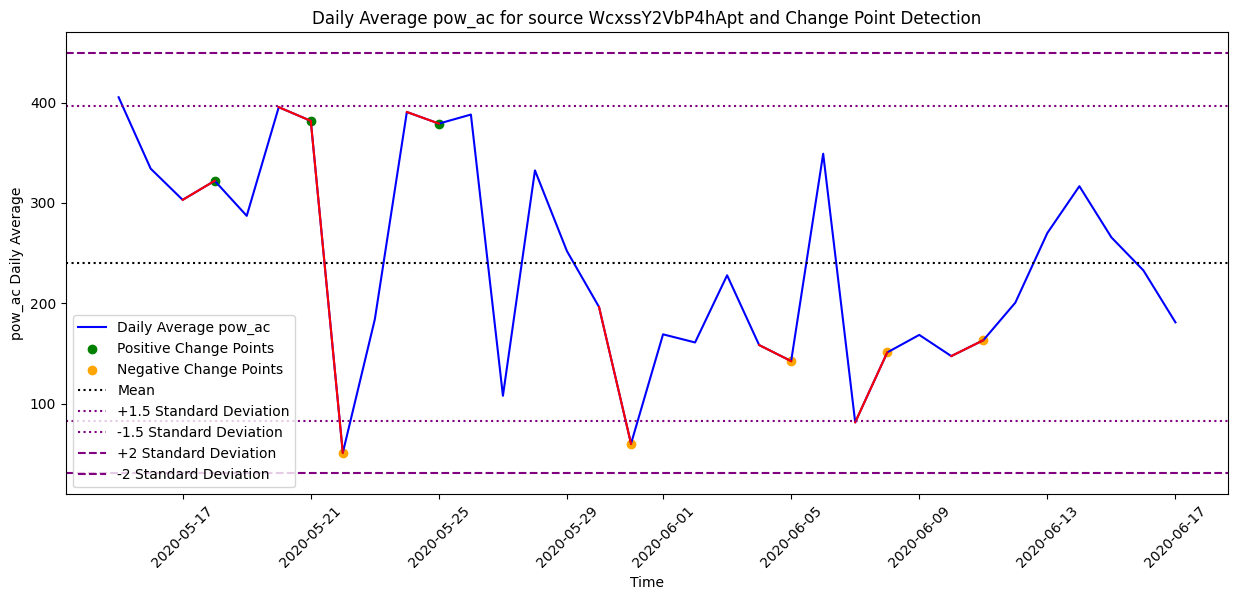

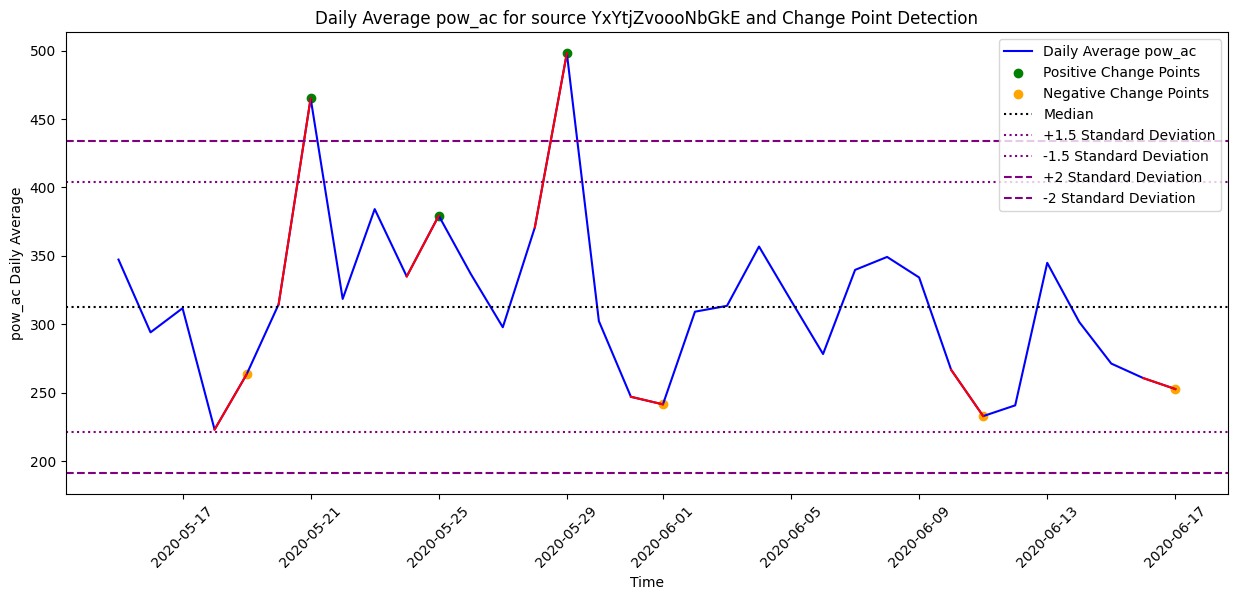

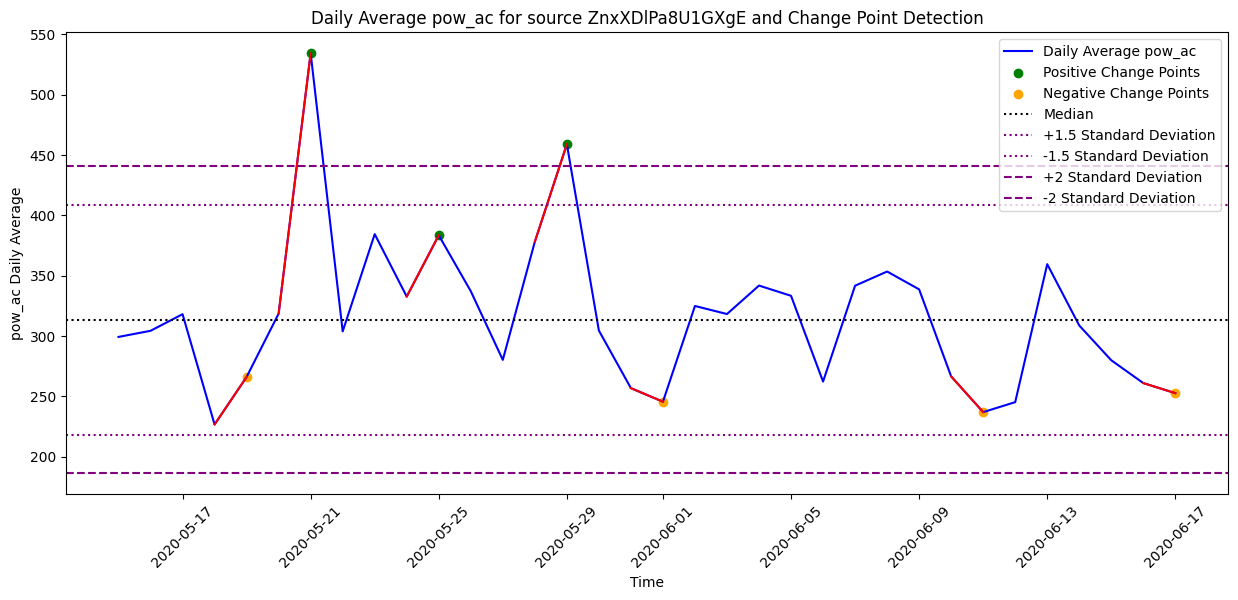

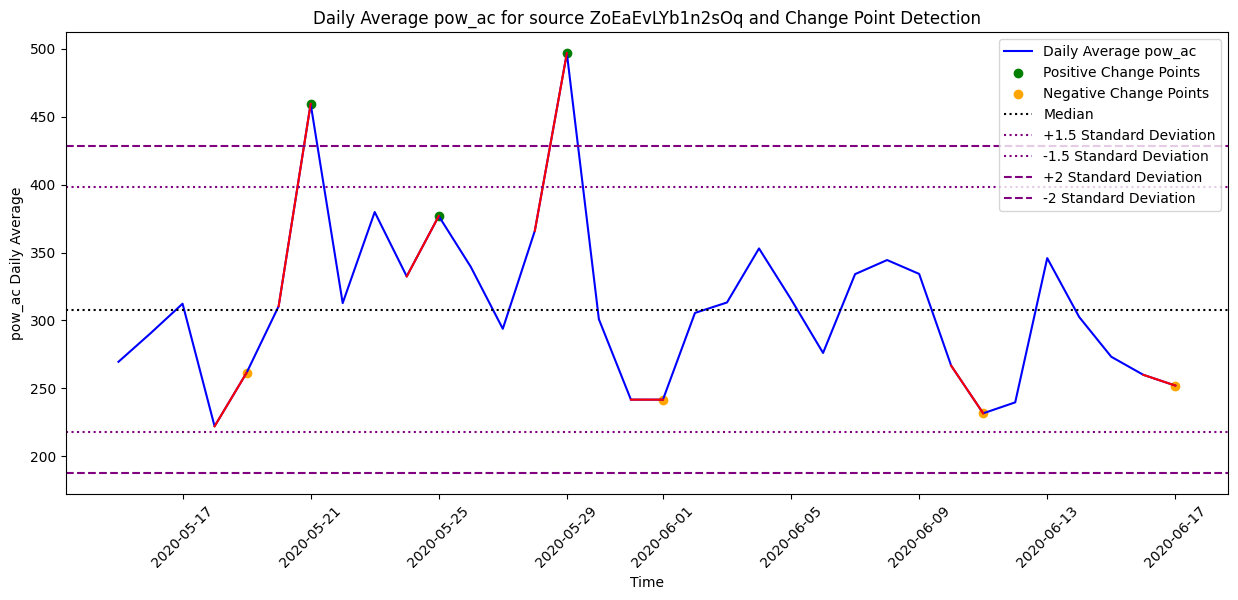

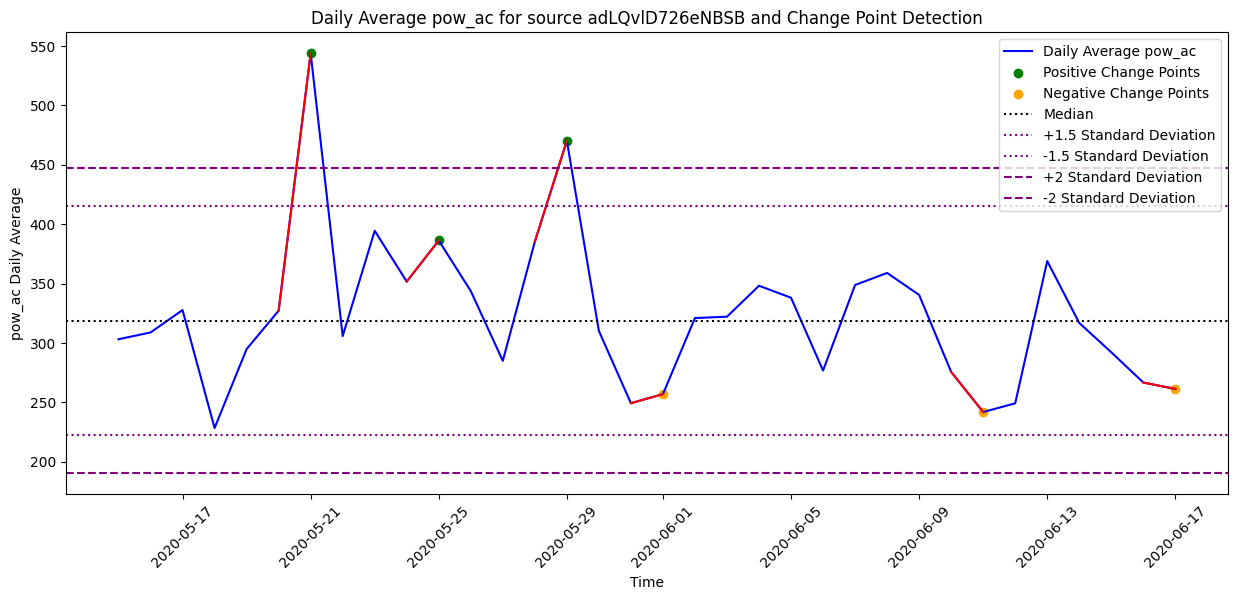

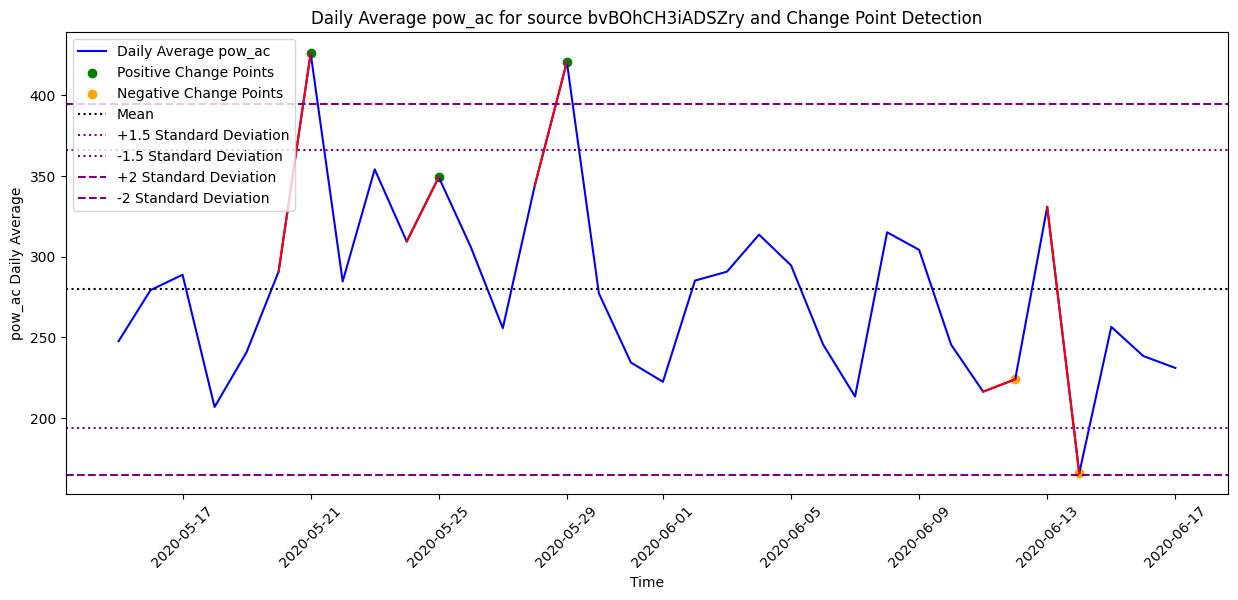

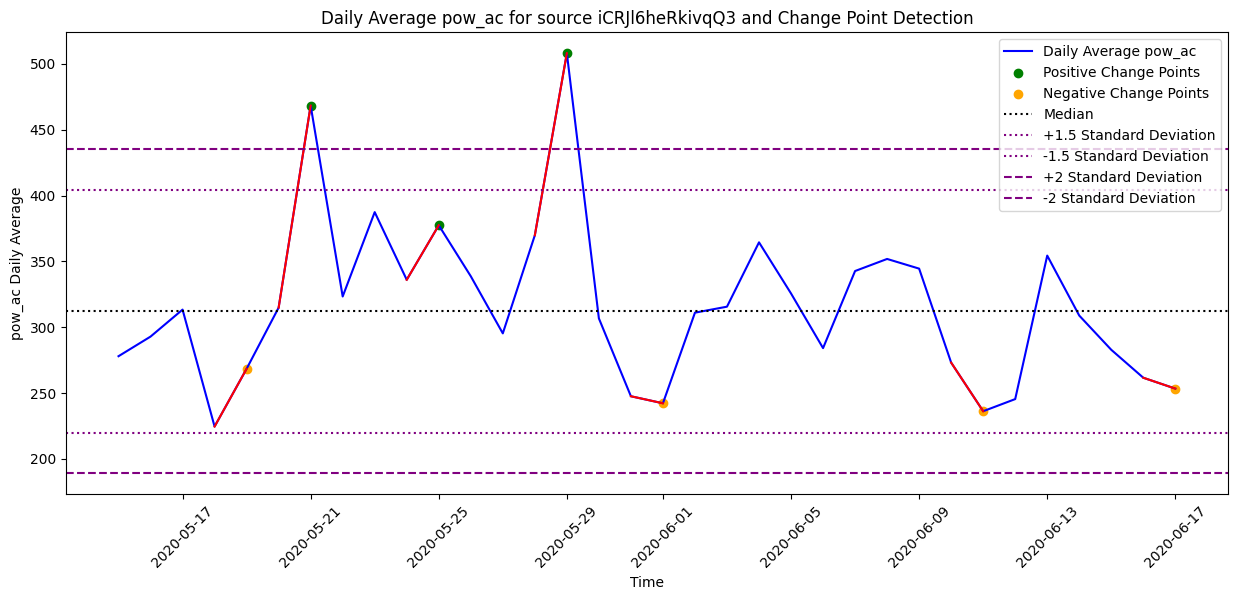

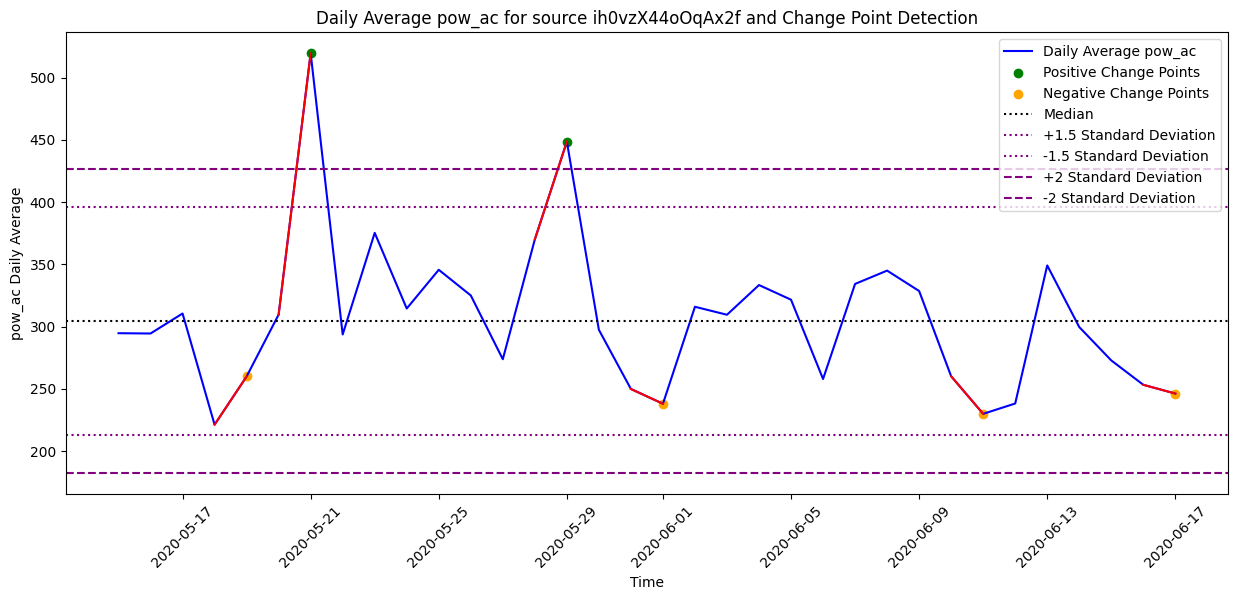

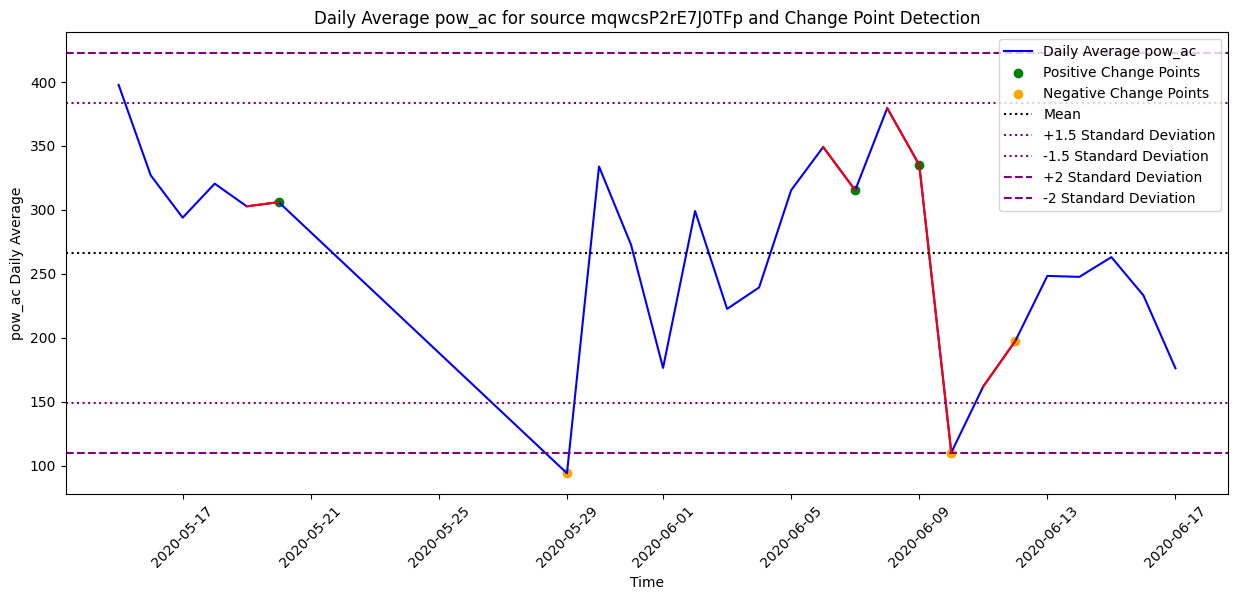

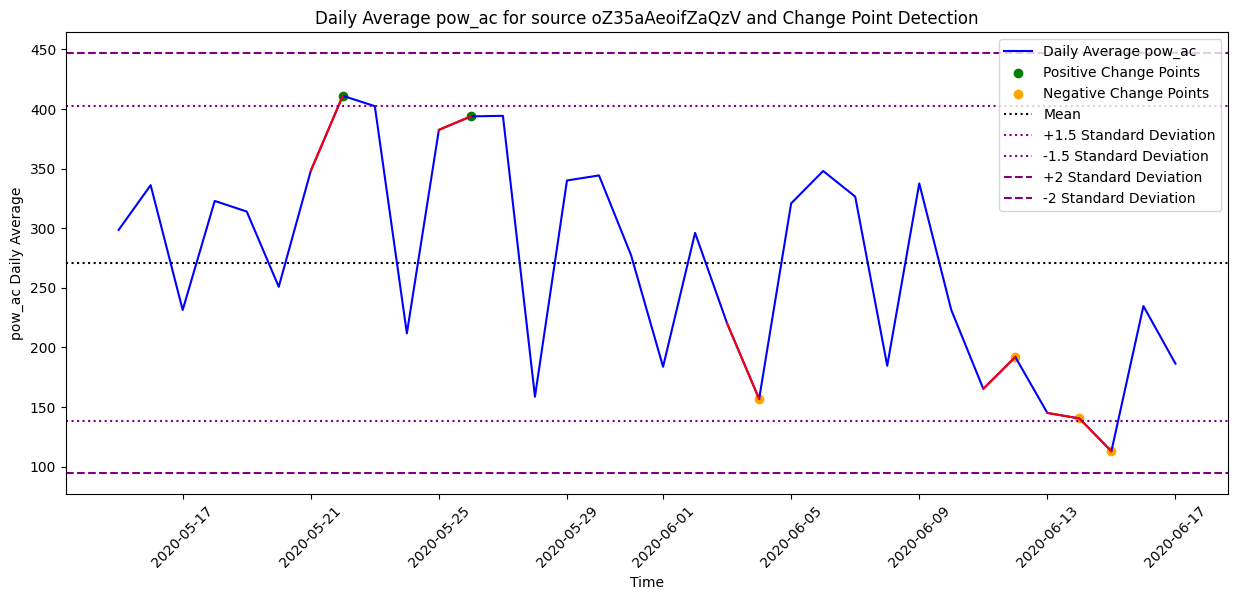

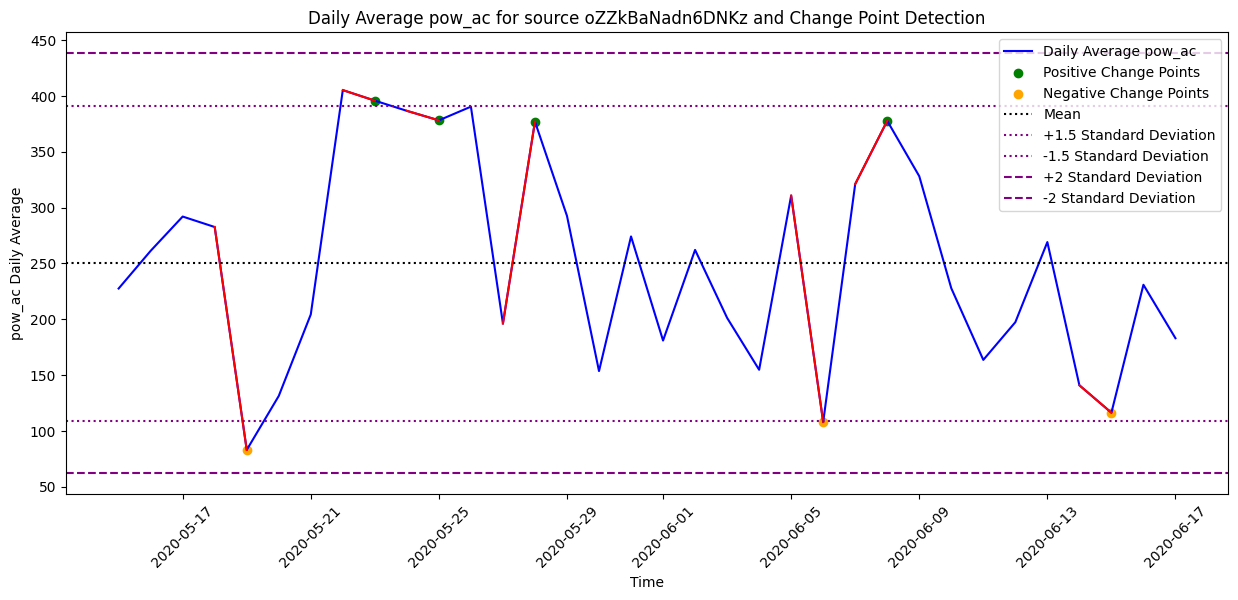

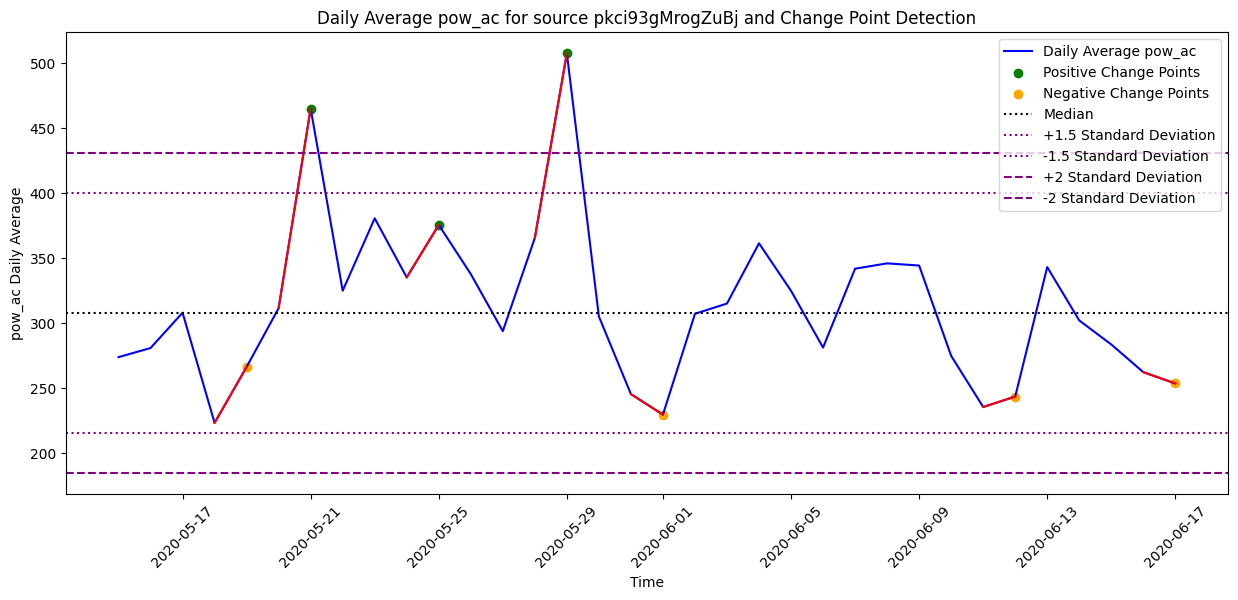

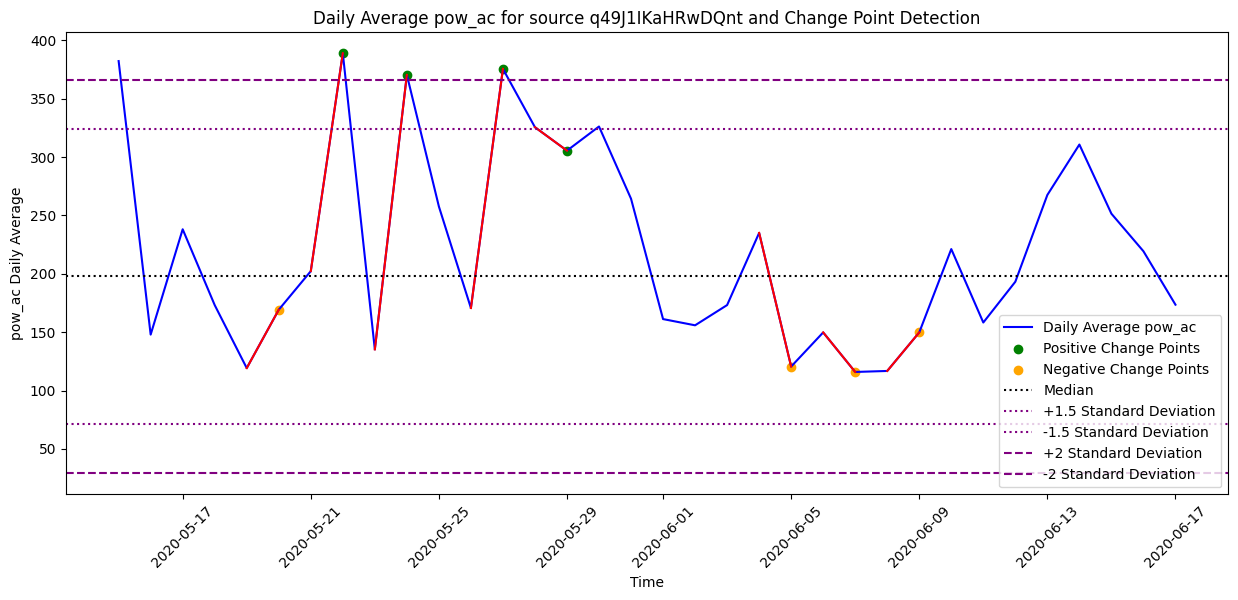

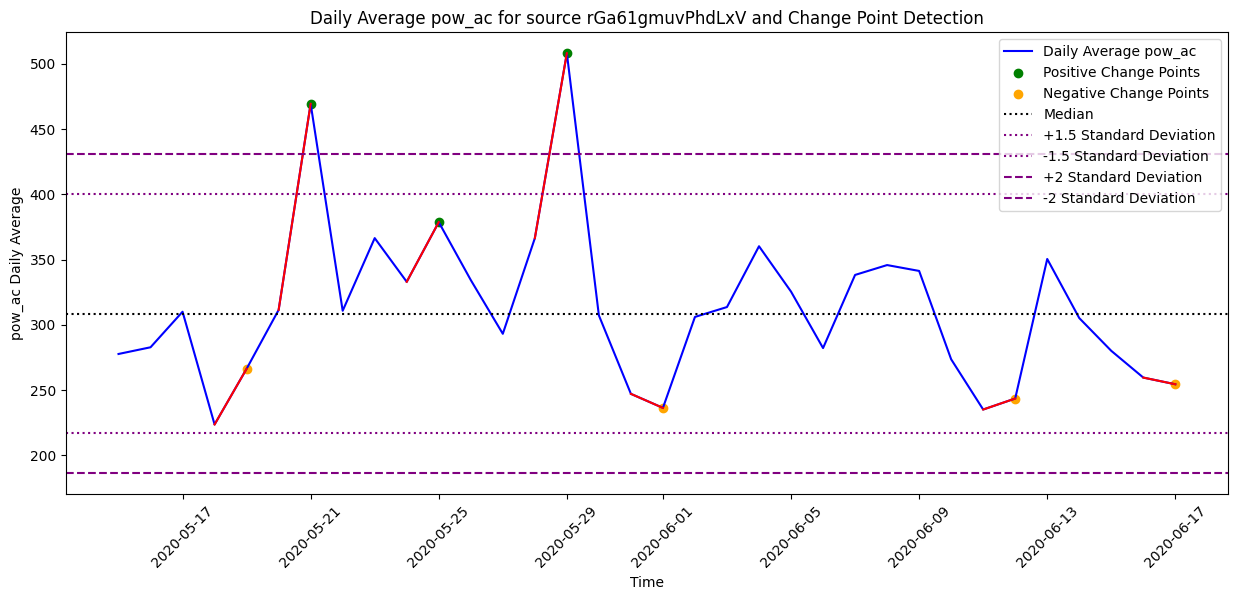

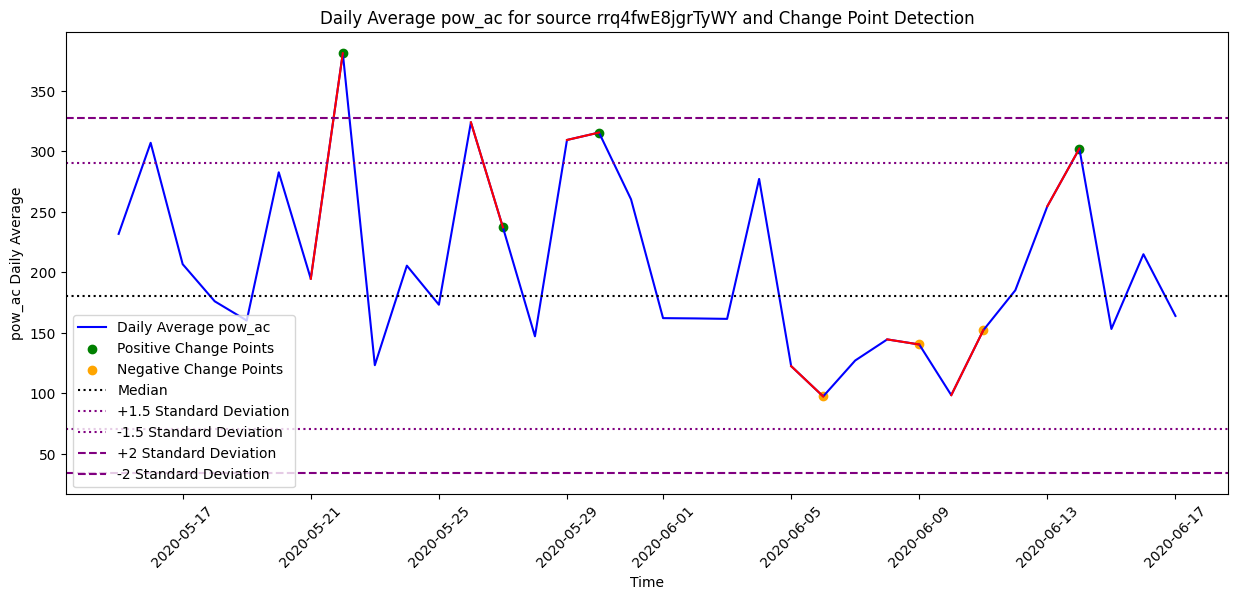

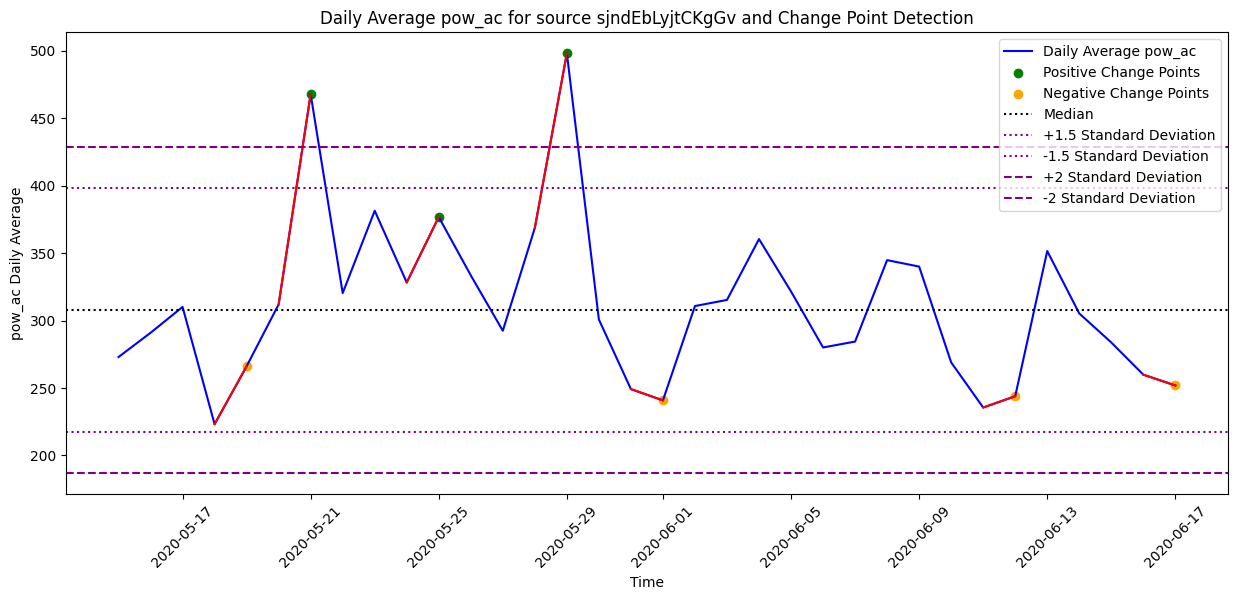

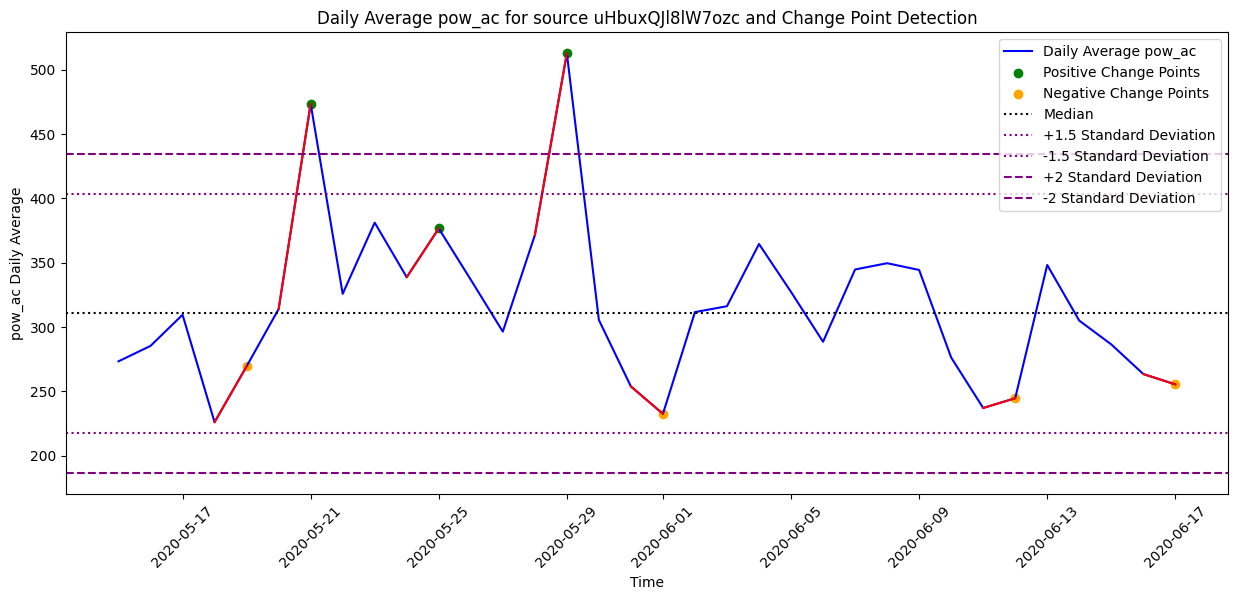

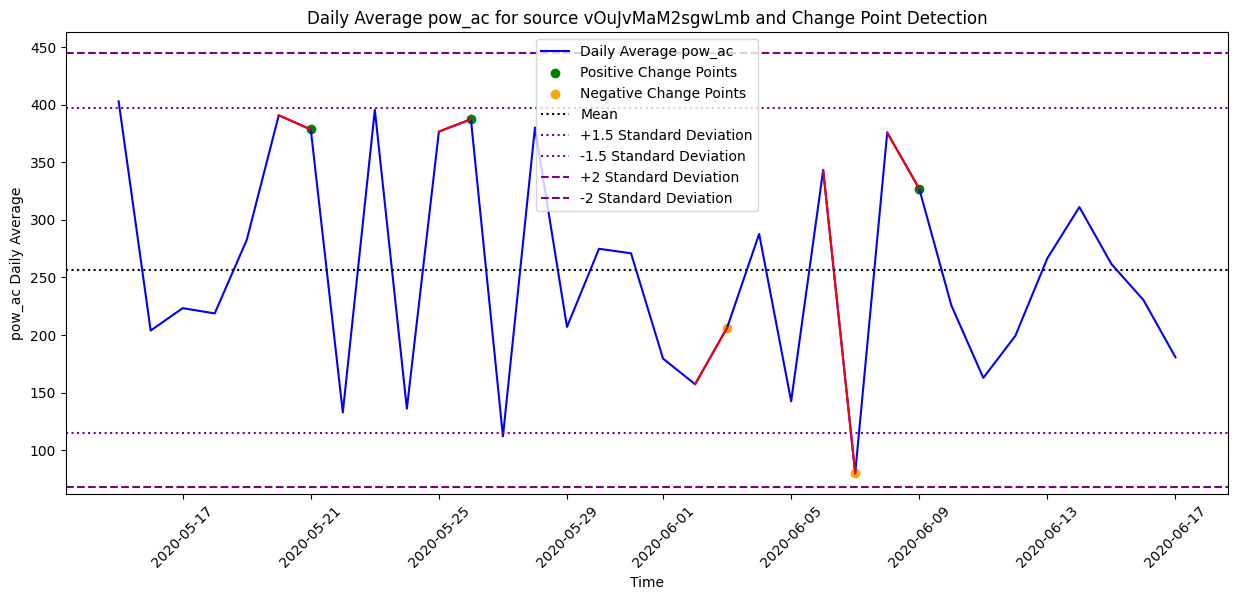

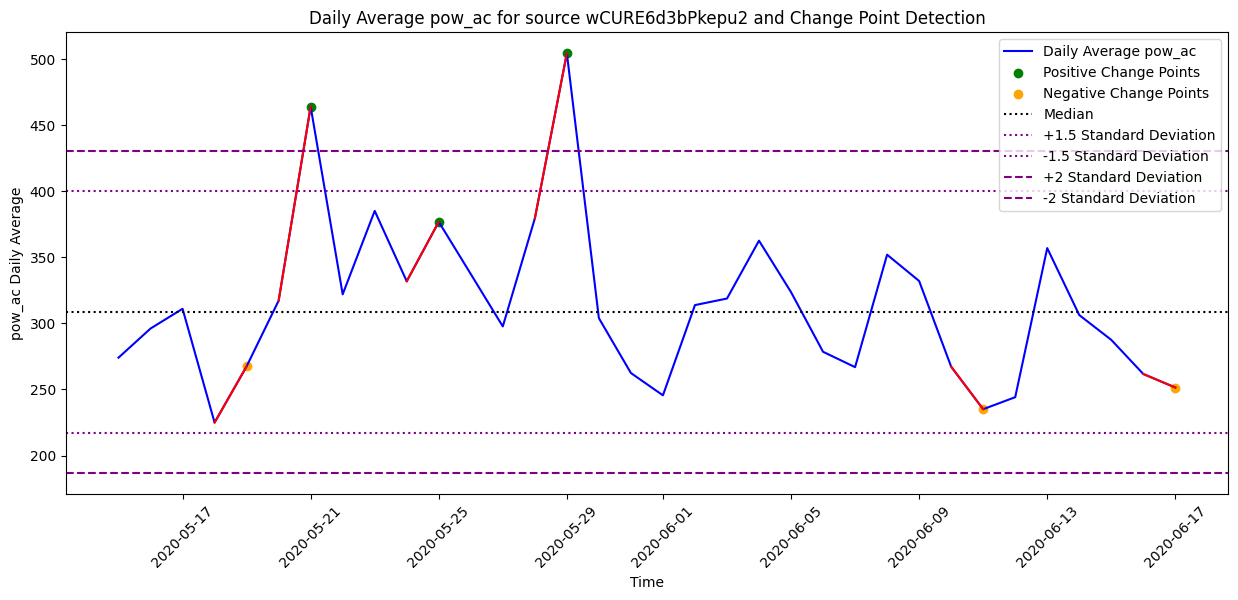

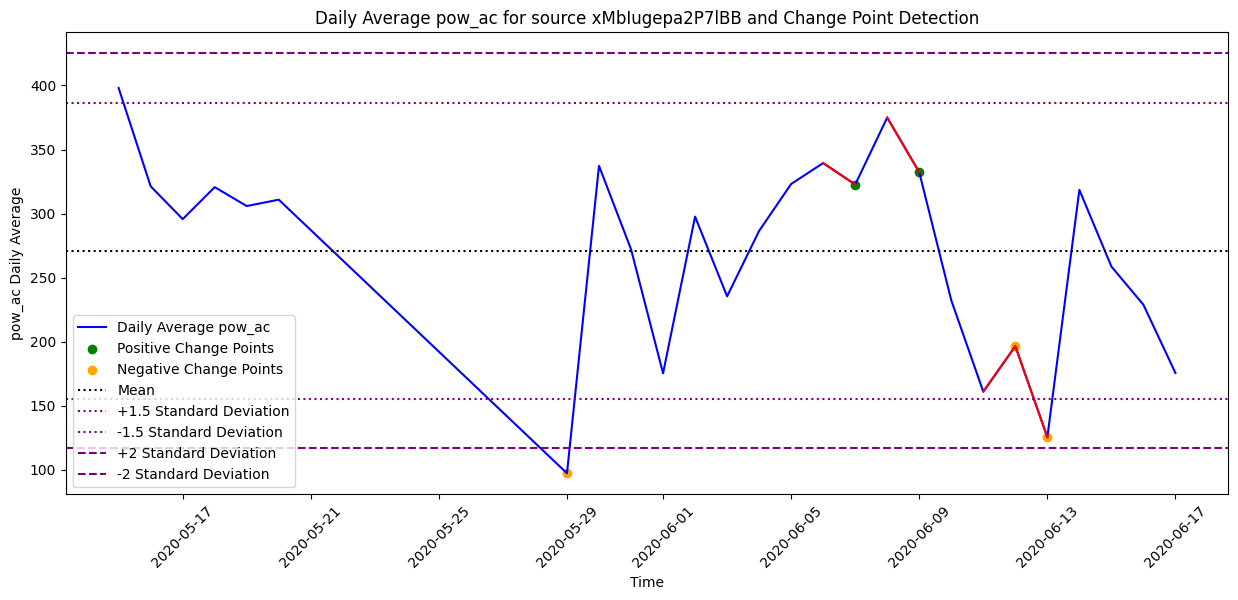

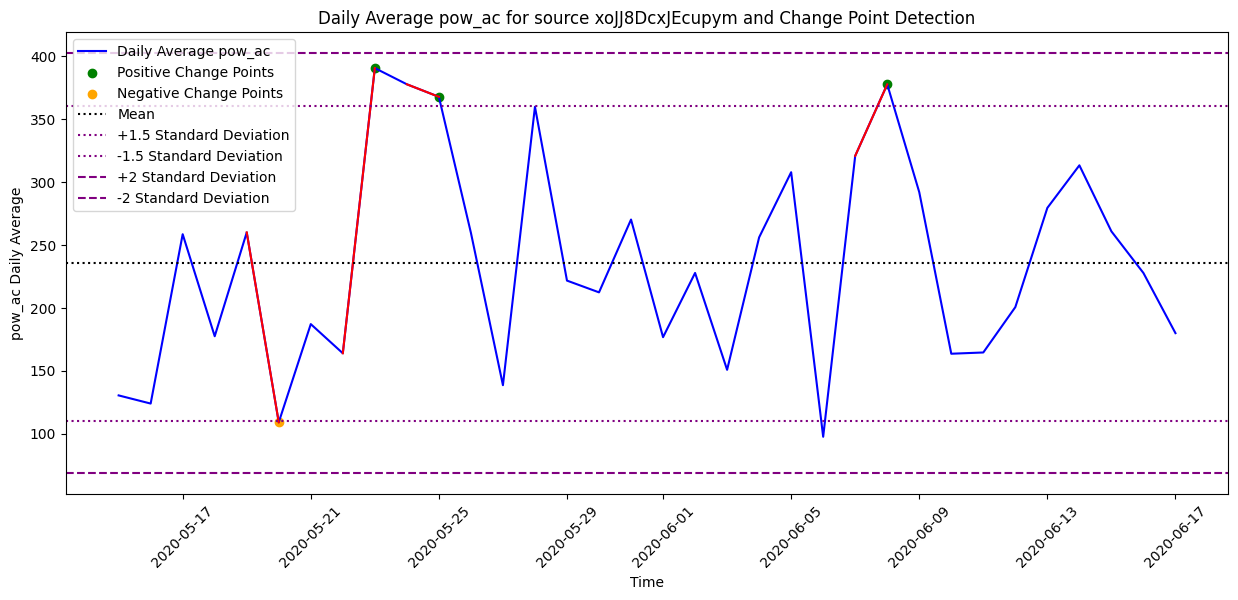

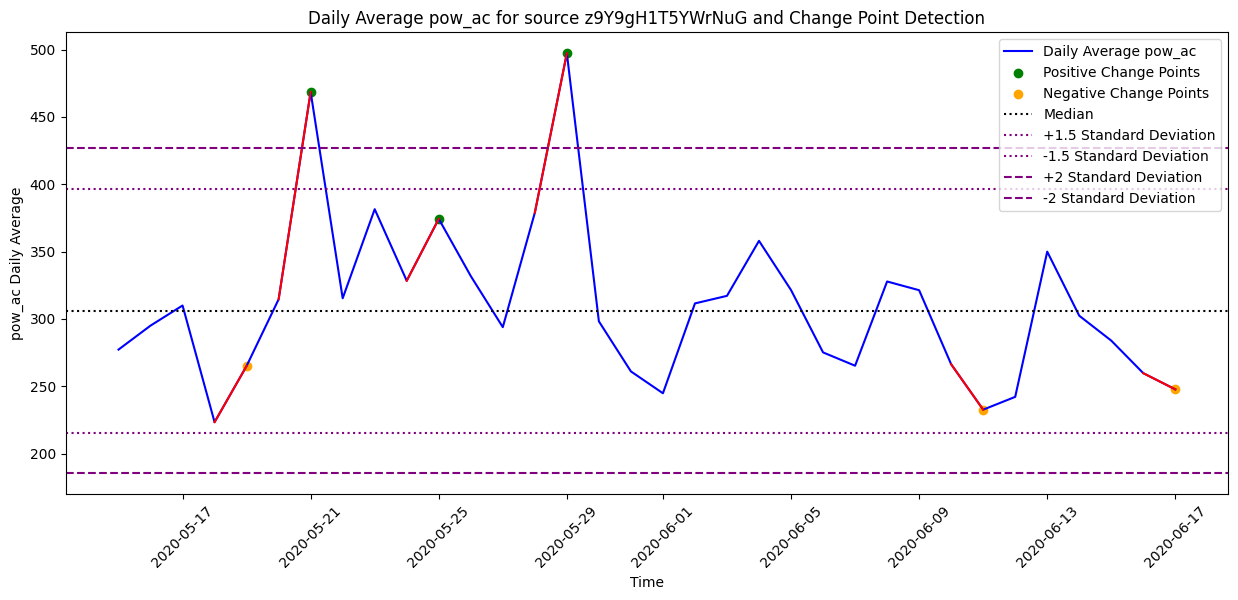

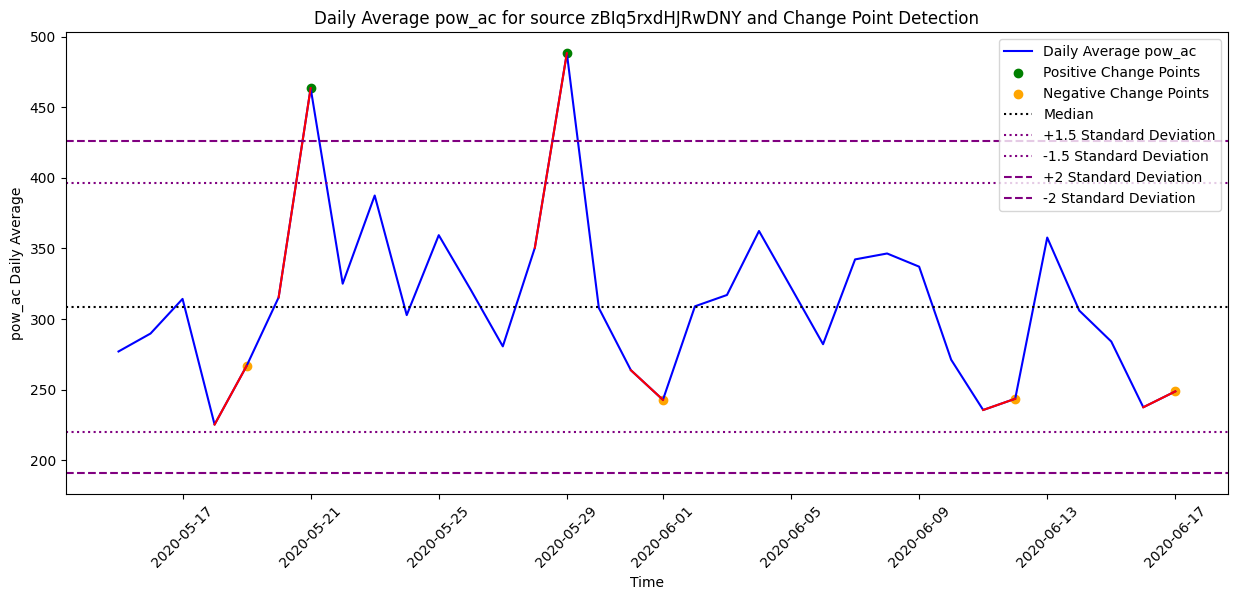

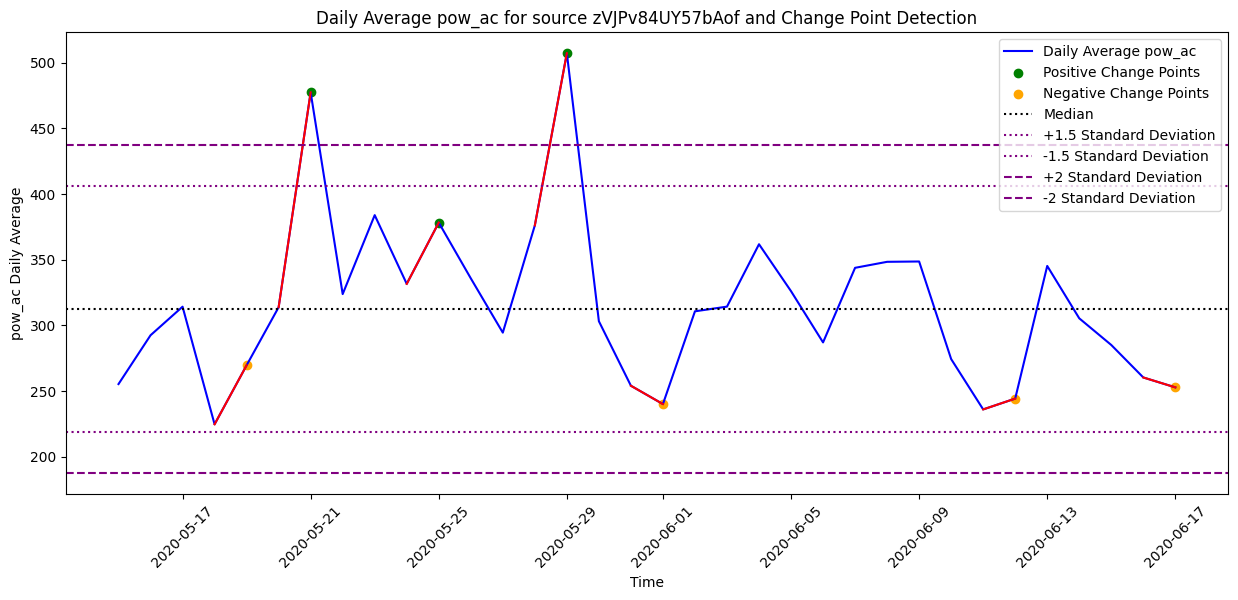

In [9]:
sources = df["sourceKey"].unique()

for source in sources:
    target = "pow_ac"
    mu_0 = 0
    k = 0.25
    h = 1.5

    d = df.loc[df.sourceKey == source][["dtm", target]].set_index("dtm")
    # Standardize data:
    scaler = StandardScaler()
    target_standardized = f"{target}_standardized"
    d[target_standardized] = scaler.fit_transform(d[[target]])

    # Shapiro-Wilk Test for Normality
    stat, p = shapiro(d[target])
    alpha = 0.05
    if p > alpha:
        central_tendency = d[target].mean()
        label = "Mean"
    else:
        central_tendency = d[target].median()
        label = "Median"
    std = d[target].std()

    # Apply CUMSUM:
    positive_flags, negative_flags = cumsum(d[target_standardized], mu_0, k, h)
    change_flags = positive_flags | negative_flags
    d['segment'] = (~change_flags).cumsum()
    change_flags_series = pd.Series(change_flags, index=d.index)

    # Plot:
    plt.figure(figsize=(15, 6))

    # Plot the entire series
    sns.lineplot(data=d, x=d.index, y=target, label=f"Daily Average {target}", color='blue')

    # Highlight segments where change points occur
    for segment in d['segment'].unique():
        segment_data = d[d['segment'] == segment]
        if change_flags_series[segment_data.index].any():
            plt.plot(segment_data.index, segment_data[target], color='red')

    # Overlay the change points as scatter dots
    positive_change_indices = d.index[positive_flags]
    negative_change_indices = d.index[negative_flags]
    plt.scatter(positive_change_indices, d.loc[positive_change_indices, target], color="green", label="Positive Change Points")
    plt.scatter(negative_change_indices, d.loc[negative_change_indices, target], color="orange", label="Negative Change Points")

    # Central Tendency Line:
    plt.axhline(y=central_tendency, color="black", linestyle=":", label=label)

    # Standard deviation lines:
    plt.axhline(y=central_tendency + 1.5 * std, color="purple", linestyle=":", label="+1.5 Standard Deviation")
    plt.axhline(y=central_tendency - 1.5 * std, color="purple", linestyle=":", label="-1.5 Standard Deviation")
    plt.axhline(y=central_tendency + 2 * std, color="purple", linestyle="--", label="+2 Standard Deviation")
    plt.axhline(y=central_tendency - 2 * std, color="purple", linestyle="--", label="-2 Standard Deviation")

    plt.title(f"Daily Average {target} for source {source} and Change Point Detection")
    plt.xlabel("Time")
    plt.ylabel(f"{target} Daily Average")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()